In [188]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings(action = 'ignore')

# pd.set_option('display.max_rows', None) # 생략안되게 나오는 방법
# pd.reset_option('display.max_rows')

In [189]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [190]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [191]:
len(df_train['response_corporate'].unique())

53

In [192]:
total = 54449 + 4850
false_ratio = 54449 / total
true_ratio = 4850 / total

print(f"False 비율: {false_ratio * 100:.2f}%")
print(f"True 비율: {true_ratio * 100:.2f}%")

False 비율: 91.82%
True 비율: 8.18%


# response True 비율 구하기

In [193]:
# response True 비율
# train
response_list = df_train['response_corporate'].unique()
df_train['res_cor'] = 0

for i in response_list:
    total_count = len(df_train[df_train['response_corporate'] == i])
    converted_count = len(df_train[(df_train['response_corporate'] == i) & (df_train['is_converted'] == True)])
    #
    if total_count != 0:
        conversion_rate = converted_count / total_count
    else:
        conversion_rate = 0
    
    df_train.loc[df_train['response_corporate'] == i, 'res_cor'] = conversion_rate


In [194]:
# test 
conditions = {
    'LGEPH': 0.089400,
    'LGEIL': 0.071327,
    'LGEAF': 0.454861,
    'LGESJ': 0.078965,
    'LGESL': 0.089080,
    'LGESP': 0.072065,
    'LGEGF': 0.124709,
    'LGESA': 0.100746,
    'LGEUS': 0.161041,
    'LGECB': 0.035594,
    'LGEMS': 0.055997,
    'LGEEG': 0.022727,
    'LGEEF': 0.031447,
    'LGEAP': 0.128415,
    'LGEIN': 0.138790,
    'LGEUK': 0.015142,
    'LGEKR': 0.004619,
    'LGEPS': 0.073482,
    'LGECI': 0.076046,
    'LGECL': 0.071695,
    'LGETK': 0.022181,
    'LGELF': 0.040146,
    'LGEPT': 0.189189,
    'LGEPR': 0.038904,
    'LGEDG': 0.049477,
    'LGERO': 0.310345,
    'LGEMK': 0.069486,
    'LGEPL': 0.070588,
    'LGECZ': 0.428571,
    'LGEES': 0.025338,
    'LGEAR': 0.173116,
    'LGEHK': 0.415144,
    'LGEML': 0.054545,
    'LGEJP': 0.000000,
    'LGEHS': 0.156863,
    'LGEAS': 0.030303,
    'LGEYK': 0.038462,
    'LGEIS': 0.007853,
    'LGEBN': 0.070707,
    'LGEFS': 0.056291,
    'LGESW': 0.096774,
    'LGEMC': 0.300000,
    'LGEAG': 0.000000,
    'LGEEB': 0.076923,
    'LGETH': 0.178378,
    'LGEVH': 0.021173,
    'LGECH': 0.030769,
    'LGELA': 0.500000,
    'LGETT': 0.553191,
    'LGERA': 0.000000,
    'LGEUR': 0.000000,
    'LGEIR': 0.000000,
    'LGEBT': 0.000000
}

df_test['res_cor'] = df_test['response_corporate'].map(conditions)


# customer_idx True 비율 구하기

In [195]:
# train 
customer_ranges = [(0, 10000), (10000, 20000), (20000, 30000), (30000, 40000), (40000, float('inf'))]
df_train['cus_cor'] = 0

# 각 범위에 대해 반복하여 'is_converted'가 True인 비율 계산
for range_start, range_end in customer_ranges:
    # 해당 범위에 해당하는 행을 선택
    selected_rows = df_train[(df_train['customer_idx'] >= range_start) & (df_train['customer_idx'] < range_end)]
    
    # 선택된 행 중 'is_converted'가 True인 행의 개수 계산
    converted_count = len(selected_rows[selected_rows['is_converted'] == True])
    
    # 선택된 행의 총 개수 계산
    total_count = len(selected_rows)
    
    # 비율 계산 및 'cus_cor' 열에 저장
    if total_count != 0:
        conversion_rate = converted_count / total_count
    else:
        conversion_rate = 0
    
    # 선택된 행의 'cus_cor' 열에 비율 값 저장
    df_train.loc[selected_rows.index, 'cus_cor'] = conversion_rate


In [196]:
# test
df_test['cus_cor'] = 0
df_test['cus_cor'].loc[df_test['customer_idx']<10000] = 0.055171
df_test['cus_cor'].loc[(df_test['customer_idx']<20000) & (df_test['customer_idx']>=10000)] = 0.052385
df_test['cus_cor'].loc[(df_test['customer_idx']<30000) & (df_test['customer_idx']>=20000)] = 0.039480
df_test['cus_cor'].loc[(df_test['customer_idx']<40000) & (df_test['customer_idx']>=30000)] = 0.226846
df_test['cus_cor'].loc[(df_test['customer_idx']>=40000)] = 0.029186

# cus_res / customer_idx True 비율 * response_coporate True 비율

In [197]:
df_train['cus_res'] = df_train['cus_cor'] * df_train['res_cor']
df_test['cus_res'] = df_test['cus_cor'] * df_test['res_cor']

### ver_win_ratio_per_bu

In [198]:
df_train['business_area'].value_counts()

business_area
corporate / office                4097
retail                            3011
hotel & accommodation             2013
special purpose                   1929
residential (home)                1818
education                         1727
hospital & health care            1199
factory                           1035
government department              650
public facility                    519
transportation                     306
power plant / renewable energy     113
Name: count, dtype: int64

In [199]:
df_train['business_area'] = df_train['business_area'].fillna('corporate / office')

df_test['business_area'] = df_test['business_area'].fillna('corporate / office')

# business_unit

In [200]:
df_train['business_unit'].loc[df_train['business_unit']=='Solution'] = 'AS'
df_train['business_unit'].loc[df_train['business_unit']=='CM'] = 'AS'

df_test['business_unit'].loc[df_test['business_unit']=='CM'] = 'AS'
df_test['business_unit'].loc[df_test['business_unit']=='Solution'] = 'AS'

In [201]:
df_test['business_unit'].value_counts()

business_unit
AS    2410
ID    2342
IT     519
Name: count, dtype: int64

## ver_win_ratio_per_bu 전처리

In [202]:
train_ver_win_ratio = df_train.groupby(['business_area', 'business_unit'])['ver_win_ratio_per_bu'].transform('mean')
test_ver_win_ratio = df_test.groupby(['business_area', 'business_unit'])['ver_win_ratio_per_bu'].transform('mean')

df_train['ver_win_ratio_per_bu'].fillna(train_ver_win_ratio, inplace = True)
df_test['ver_win_ratio_per_bu'].fillna(test_ver_win_ratio, inplace = True)

## business_unit 원-핫인코딩

In [203]:
df_train = pd.get_dummies(df_train, columns = ['business_unit'])
df_test = pd.get_dummies(df_test, columns = ['business_unit'])

df_train = df_train.drop('business_unit_IT', axis=1)
df_test = df_test.drop('business_unit_IT', axis=1)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   com_reg_ver_win_rate     14568 non-null  float64
 3   customer_idx             59299 non-null  int64  
 4   customer_type            15338 non-null  object 
 5   enterprise               59299 non-null  object 
 6   historical_existing_cnt  13756 non-null  float64
 7   id_strategic_ver         3444 non-null   float64
 8   it_strategic_ver         1121 non-null   float64
 9   idit_strategic_ver       4565 non-null   float64
 10  customer_job             40566 non-null  object 
 11  lead_desc_length         59299 non-null  int64  
 12  inquiry_type             58358 non-null  object 
 13  product_category         39925 non-null  object 
 14  product_subcategory   

# as_strategic_ver 컬럼 생성

In [204]:
# as_strategic_ver 컬럼 생성 
df_train['as_strategic_ver']= df_train['id_strategic_ver']
df_train['as_strategic_ver'] = 0
df_train['as_strategic_ver'].loc[df_train['business_area']=='hotel & accommodation'] = 1
df_train['as_strategic_ver'].loc[df_train['business_area']=='corporate / office'] = 1
df_train['as_strategic_ver'].loc[df_train['ver_cus']== 1 ] = 1
df_train['as_strategic_ver'].loc[df_train['ver_pro']== 1 ] = 1


# iditas_strategic_ver 생성
df_train['iditas_strategic_ver'] = df_train['idit_strategic_ver']
df_train['iditas_strategic_ver'].loc[df_train['as_strategic_ver']== 1 ] = 1

# idit_strategic_ver 제거 
df_train = df_train.drop(['idit_strategic_ver'],axis=1)




# as_strategic_ver 컬럼 생성 
df_test['as_strategic_ver'] = df_test['id_strategic_ver']
df_test['as_strategic_ver'] = 0
df_test['as_strategic_ver'].loc[df_test['business_area'] == 'hotel & accommodation'] = 1
df_test['as_strategic_ver'].loc[df_test['business_area'] == 'corporate / office'] = 1
df_test['as_strategic_ver'].loc[df_test['ver_cus'] == 1] = 1
df_test['as_strategic_ver'].loc[df_test['ver_pro'] == 1] = 1

# iditas_strategic_ver 생성
df_test['iditas_strategic_ver'] = df_test['idit_strategic_ver']
df_test['iditas_strategic_ver'].loc[df_test['as_strategic_ver'] == 1] = 1

# idit_strategic_ver 제거 
df_test = df_test.drop(['idit_strategic_ver'], axis=1)


In [205]:
df_train.groupby('business_area')[['ver_win_rate_x']].value_counts()

business_area                   ver_win_rate_x
corporate / office              0.003079          4097
education                       0.000572          1727
factory                         0.000215          1035
government department           0.000097           650
hospital & health care          0.000060          1199
hotel & accommodation           0.000717          2013
power plant / renewable energy  0.000002           113
public facility                 0.000026           519
residential (home)              0.000298          1818
retail                          0.001183          3011
special purpose                 0.000543          1929
transportation                  0.000013           306
Name: count, dtype: int64

In [206]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   com_reg_ver_win_rate     14568 non-null  float64
 3   customer_idx             59299 non-null  int64  
 4   customer_type            15338 non-null  object 
 5   enterprise               59299 non-null  object 
 6   historical_existing_cnt  13756 non-null  float64
 7   id_strategic_ver         3444 non-null   float64
 8   it_strategic_ver         1121 non-null   float64
 9   customer_job             40566 non-null  object 
 10  lead_desc_length         59299 non-null  int64  
 11  inquiry_type             58358 non-null  object 
 12  product_category         39925 non-null  object 
 13  product_subcategory      9235 non-null   object 
 14  product_modelname     

# inquiry_type

In [207]:
inquiry = df_train['inquiry_type']
inquiry = pd.DataFrame(inquiry)


# 견적 및 구매상담 
inquiry.loc[inquiry['inquiry_type'] == 'Quotation or Purchase Consultation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Request for quotation or purchase'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'quotation_or_purchase_consultation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Purchase or Quotation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Purchase'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Quotation or Purchase consultation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Probeam precio'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'tôi cần tham khảo giá và giải pháp từ LG'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Vui lòng báo giá giúp mình sản phẩm đo thân nhiệt Xin cảm ơn'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución One Quick:'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Preciso de um monitor médico para radiografia convencional e tomogrtafia.'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'estoy buscando para Ecuador este producto LG MAGNIT micro LED, para un cliente de 138 pulgadas, con envió marítimo.'] = 'Quotation or purchase consultation'

# 핀매문의
inquiry.loc[inquiry['inquiry_type'] == 'sales'] = 'Sales Inquiry'
inquiry.loc[inquiry['inquiry_type'] == 'Sales inquiry'] = 'Sales Inquiry'


# 사용법 / 기술상담
inquiry.loc[inquiry['inquiry_type'] == 'Technical Consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'usage or technical consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Request for technical consulting'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'usage_or_technical_consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'technical'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'technical_consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Usage or Technical Consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Technical Support'] = 'Usage or technical consultation'

# 가맹점
inquiry.loc[inquiry['inquiry_type'] == 'Request a Demo'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Request for Partnership'] = 'Usage or technical consultation'



# 등등 
inquiry.loc[inquiry['inquiry_type'] == 'Evento_SdelEstero'] = 'Other'
inquiry.loc[inquiry['inquiry_type'] == 'ETC.'] = 'Other'
inquiry.loc[inquiry['inquiry_type'] == 'Others'] = 'Other'
inquiry.loc[inquiry['inquiry_type'] == 'other_'] = 'Other'

inquiry.loc[(inquiry['inquiry_type'] != 'Quotation or purchase consultation')
           & (inquiry['inquiry_type'] != 'Sales Inquiry')
           & (inquiry['inquiry_type'] != 'Usage or technical consultation')
           & (inquiry['inquiry_type'] != 'Other')
           & (inquiry['inquiry_type'] != 'Trainings')
           & (inquiry['inquiry_type'] != 'Services')
           & (inquiry['inquiry_type'] != 'Request for Distributorship')
           ] = 'Other'

df_train['inquiry_type'] = inquiry['inquiry_type']
df_train['inquiry_type'].value_counts()

inquiry_type
Quotation or purchase consultation    42393
Sales Inquiry                         10081
Other                                  3642
Usage or technical consultation        2259
Trainings                               434
Services                                415
Request for Distributorship              75
Name: count, dtype: int64

In [208]:
inquiry = df_test['inquiry_type']
inquiry = pd.DataFrame(inquiry)


# 견적 및 구매상담 
inquiry.loc[inquiry['inquiry_type'] == 'Quotation or Purchase Consultation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Request for quotation or purchase'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'quotation_or_purchase_consultation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Purchase or Quotation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Purchase'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Quotation or Purchase consultation'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Probeam precio'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'tôi cần tham khảo giá và giải pháp từ LG'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Vui lòng báo giá giúp mình sản phẩm đo thân nhiệt Xin cảm ơn'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Solicito apoyo para realizar cotizacion de los dispositivos que ofrecen en la solución One Quick:'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Preciso de um monitor médico para radiografia convencional e tomogrtafia.'] = 'Quotation or purchase consultation'
inquiry.loc[inquiry['inquiry_type'] == 'estoy buscando para Ecuador este producto LG MAGNIT micro LED, para un cliente de 138 pulgadas, con envió marítimo.'] = 'Quotation or purchase consultation'

# 핀매문의
inquiry.loc[inquiry['inquiry_type'] == 'sales'] = 'Sales Inquiry'
inquiry.loc[inquiry['inquiry_type'] == 'Sales inquiry'] = 'Sales Inquiry'


# 사용법 / 기술상담
inquiry.loc[inquiry['inquiry_type'] == 'Technical Consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'usage or technical consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Request for technical consulting'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'usage_or_technical_consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'technical'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'technical_consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Usage or Technical Consultation'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Technical Support'] = 'Usage or technical consultation'

# 가맹점
inquiry.loc[inquiry['inquiry_type'] == 'Request a Demo'] = 'Usage or technical consultation'
inquiry.loc[inquiry['inquiry_type'] == 'Request for Partnership'] = 'Usage or technical consultation'



# 등등 
inquiry.loc[inquiry['inquiry_type'] == 'Evento_SdelEstero'] = 'Other'
inquiry.loc[inquiry['inquiry_type'] == 'ETC.'] = 'Other'
inquiry.loc[inquiry['inquiry_type'] == 'Others'] = 'Other'
inquiry.loc[inquiry['inquiry_type'] == 'other_'] = 'Other'

inquiry.loc[(inquiry['inquiry_type'] != 'Quotation or purchase consultation')
           & (inquiry['inquiry_type'] != 'Sales Inquiry')
           & (inquiry['inquiry_type'] != 'Usage or technical consultation')
           & (inquiry['inquiry_type'] != 'Other')
           & (inquiry['inquiry_type'] != 'Trainings')
           & (inquiry['inquiry_type'] != 'Services')
           & (inquiry['inquiry_type'] != 'Request for Distributorship')
           ] = 'Other'

df_test['inquiry_type'] = inquiry['inquiry_type']
df_test['inquiry_type'].value_counts()

inquiry_type
Quotation or purchase consultation    3465
Other                                 1491
Usage or technical consultation        259
Services                                34
Trainings                               21
Request for Distributorship              1
Name: count, dtype: int64

# Customer_type

In [209]:
# End Customer
df_train['customer_type'].loc[df_train['customer_type'] == 'End-Customer'] = 'End Customer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Home Owner'] = 'End Customer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Homeowner'] = 'End Customer'
df_train['customer_type'].loc[df_train['customer_type'] == 'End-user'] = 'End Customer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Commercial end-user'] = 'End Customer'

# Specifier/ Influencer
df_train['customer_type'].loc[df_train['customer_type'] == 'Consultant'] = 'Specifier/ Influencer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Architect/Consultant'] = 'Specifier/ Influencer'
df_train['customer_type'].loc[df_train['customer_type'] == 'HVAC Engineer'] = 'Specifier/ Influencer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Engineer'] = 'Specifier/ Influencer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Developer'] = 'Specifier/ Influencer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Manager / Director'] = 'Specifier/ Influencer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Technical Assistant'] = 'Specifier/ Influencer'
df_train['customer_type'].loc[df_train['customer_type'] == 'Administrator'] = 'Specifier/ Influencer'

# Channel Partner / 제품을 판매하고 보급하는 업무
df_train['customer_type'].loc[df_train['customer_type'] == 'Reseller'] = 'Channel Partner'
df_train['customer_type'].loc[df_train['customer_type'] == 'Distributor'] = 'Channel Partner'
df_train['customer_type'].loc[df_train['customer_type'] == 'Dealer/Distributor'] = 'Channel Partner'
df_train['customer_type'].loc[df_train['customer_type'] == 'System Integrator'] = 'Channel Partner'

# Service Partner / 서비스 관련 업무 
df_train['customer_type'].loc[df_train['customer_type'] == 'Installer/Contractor'] = 'Service Partner'
df_train['customer_type'].loc[df_train['customer_type'] == 'Technician'] = 'Service Partner'
df_train['customer_type'].loc[df_train['customer_type'] == 'Interior Designer'] = 'Service Partner'

#Other
df_train['customer_type'].loc[df_train['customer_type'] == 'Corporate'] = 'Other'
df_train['customer_type'].loc[df_train['customer_type'] == 'Software/Solution Provider'] = 'Other'
df_train['customer_type'].loc[df_train['customer_type'] == 'Etc.'] = 'Other'
df_train['customer_type'].loc[df_train['customer_type'] == 'Installer'] = 'Other'
df_train['customer_type'].loc[df_train['customer_type'] == 'Others'] = 'Other'
df_train['customer_type'].loc[df_train['customer_type'] == 'Software / Solution Provider'] = 'Other'

df_test['customer_type'].loc[df_test['customer_type'] == 'End-user'] = 'End Customer'
df_test['customer_type'].loc[df_test['customer_type'] == 'Developer'] = 'Other'

# customer_count

In [210]:
# customer_idx 개수 세기
df_idx = df_train['customer_idx'].value_counts().reset_index()
df_idx.columns = ['customer_idx', 'count']

# Merge f_train with f_idx on 'customer_idx'
merged_df = pd.merge(df_train, df_idx, on='customer_idx', how='left')

# Update 'customer_count' in f_train where matches were found
df_train['customer_count'] = merged_df['count'].fillna(0).astype(int)



# customer_idx 개수 세기
df_idx = df_test['customer_idx'].value_counts().reset_index()
df_idx.columns = ['customer_idx', 'count']

# Merge f_train with f_idx on 'customer_idx'
merged_df = pd.merge(df_test, df_idx, on='customer_idx', how='left')

# Update 'customer_count' in f_train where matches were found
df_test['customer_count'] = merged_df['count'].fillna(0).astype(int)

In [211]:
df_train['customer_idx'].value_counts()

customer_idx
47466    7686
25096    2421
37680     367
18030     331
21321     162
         ... 
39487       1
41241       1
39422       1
22515       1
30268       1
Name: count, Length: 35112, dtype: int64

# expected_timepline

In [212]:
# Na ' ' 변경
df_train['expected_timeline'].fillna('Nothing', inplace=True)

# _ 제거
df_train['expected_timeline'] = df_train['expected_timeline'].str.replace("_",' ')

# 3 개월 미만
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 'less than 3 months' if '1' in x  else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 'less than 3 months' if '2' in x  else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 'less than 3 months' if 'ㅣess than 3 months' in x  else x)


# 3 ~ 6 개울
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if '3' in x and '6' in x else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if 'more then 3 months' in x  else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if 'less than 6 months' in x  else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if '4' in x  else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if '5' in x  else x)

# 6 ~ 9 개월
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '6 months ~ 9 months' if '6' in x and '9' in x else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '6 months ~ 9 months' if '7' in x  else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '6 months ~ 9 months' if '8' in x  else x)

# 9 ~ 12 개월
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '9 months ~ 1 year' if '9' in x and '1' in x else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '9 months ~ 1 year' if '10' in x  else x)
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: '9 months ~ 1 year' if '11' in x  else x)

# 1년이상
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 'more than a year' if 'a year' in x  else x)

# 나머지 
df_train['expected_timeline'] = df_train['expected_timeline'].apply(lambda x: 'no mean' 
                                                                    if x not in ['less than 3 months', 
                                                                                 '3 months ~ 6 months', 
                                                                                 '6 months ~ 9 months', 
                                                                                 '9 months ~ 1 year', 
                                                                                 'more than a year',
                                                                                'Nothing'] 
                                                                    else x)

# Na ' ' 변경
df_test['expected_timeline'].fillna('Nothing', inplace=True)

# _ 제거
df_test['expected_timeline'] = df_test['expected_timeline'].str.replace("_",' ')

# 3 개월 미만
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 'less than 3 months' if '1' in x  else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 'less than 3 months' if '2' in x  else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 'less than 3 months' if 'ㅣess than 3 months' in x  else x)


# 3 ~ 6 개월
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if '3' in x and '6' in x else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if 'more then 3 months' in x  else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if 'less than 6 months' in x  else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if '4' in x  else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '3 months ~ 6 months' if '5' in x  else x)

# 6 ~ 9 개월
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '6 months ~ 9 months' if '6' in x and '9' in x else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '6 months ~ 9 months' if '7' in x  else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '6 months ~ 9 months' if '8' in x  else x)

# 9 ~ 12 개월
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '9 months ~ 1 year' if '9' in x and '1' in x else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '9 months ~ 1 year' if '10' in x  else x)
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: '9 months ~ 1 year' if '11' in x  else x)

# 1년이상
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 'more than a year' if 'a year' in x  else x)

# 나머지 
df_test['expected_timeline'] = df_test['expected_timeline'].apply(lambda x: 'no mean' 
                                                                    if x not in ['less than 3 months', 
                                                                                 '3 months ~ 6 months', 
                                                                                 '6 months ~ 9 months', 
                                                                                 '9 months ~ 1 year', 
                                                                                 'more than a year',
                                                                                'Nothing'] 
                                                                    else x)


# product_category

In [213]:
subcategory_mapping = {'TR3|TC3|TN3|TA3|createboard|Interactive|idb|Touch|Window Facing' : 'interactive signage',
                      'Viedo Wall|VL5|VM5E|LV3|VM5|VL7|VH7|wallOutdoor|XE4F|XF3' : 'video wall signage',
                      'LED|Ultra|All-in-One|MAGNIT|Premium|one|Quick|oled|led' : 'led signage',
                      'US660H|LU640H|UT781H|LT660H|US761H|LT340H|US662H|UT670H|UT770H|US670|US342H|ET961H|UQ801|LS341H|LT560H|LT661H|UT782H|UHD|awz|bwz' : 'hotel tv',
                       'X-ray' : 'medical display',
                       'Monitors' : 'monitor',
                       'LT340C|SM5J|SM5K|UH5F|UH7F|UL3J|UR640S|UM3DG|UM5J|SM3G|stand' : 'standard signage',
                      'interactive digital board' : 'interactive digital board',
                      'vrf' : 'vrf',
                      'multi-split' : 'multi-split',
                      'single-split' : 'single-split',
                      'rac' : 'rac',
                      'monitor' : 'monitor',
                      'chiller' : 'chiller',
                      'heating' : 'heating'}

#train
# product_category 열 값에 따라 매핑된 값을 대체
for key, value in subcategory_mapping.items():
    df_train['product_category'].loc[df_train['product_category'].str.contains(key, na=False)] = value

for key, value in subcategory_mapping.items():
    df_train['product_category'].loc[df_train['product_subcategory'].str.contains(key, na=False)] = value
    
for key, value in subcategory_mapping.items():
    df_train['product_category'].loc[df_train['product_modelname'].str.contains(key, na=False)] = value
    
    
for key, value in subcategory_mapping.items():
    df_test['product_category'].loc[df_test['product_category'].str.contains(key, na=False)] = value

for key, value in subcategory_mapping.items():
    df_test['product_category'].loc[df_test['product_subcategory'].str.contains(key, na=False)] = value
    
for key, value in subcategory_mapping.items():
    df_test['product_category'].loc[df_test['product_modelname'].str.contains(key, na=False)] = value

# lead_cor

In [214]:
lead_list = df_train['lead_owner'].unique()
df_train['lead_cor'] = 0


for i in lead_list:
    total_count = len(df_train[df_train['lead_owner'] == i])
    converted_count = len(df_train[(df_train['lead_owner'] == i) & (df_train['is_converted'] == True)])
    #
    if total_count != 0:
        conversion_rate = converted_count / total_count
    else:
        conversion_rate = 0
    
    df_train.loc[df_train['lead_owner'] == i, 'lead_cor'] = conversion_rate

df_test['lead_cor'] = df_test['lead_owner'].map(df_train.set_index('lead_owner')['lead_cor'].to_dict())


# win_ratio

In [215]:
columns_to_fill = ['ver_win_rate_x', 'ver_win_ratio_per_bu', 'com_reg_ver_win_rate', 'lead_cor']
df_train[columns_to_fill] = df_train[columns_to_fill].fillna(0)

df_train['win_ratio'] = df_train['ver_win_rate_x'] + df_train['ver_win_ratio_per_bu'] + df_train['com_reg_ver_win_rate'] + df_train['lead_cor']



columns_to_fill = ['ver_win_rate_x', 'ver_win_ratio_per_bu', 'com_reg_ver_win_rate', 'lead_cor']
df_test[columns_to_fill] = df_test[columns_to_fill].fillna(0)

df_test['win_ratio'] = df_test['ver_win_rate_x'] + df_test['ver_win_ratio_per_bu'] + df_test['com_reg_ver_win_rate'] + df_test['lead_cor']

## country 성중이꺼

In [216]:
df_train['customer_country'] = df_train['customer_country.1'].apply(lambda x: x.split('/')[1] if pd.notna(x) and '/' in x else pd.NA)
df_train['customer_country'] = df_train['customer_country'].str.replace(" ",'')

In [217]:
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEPH'] = 'Philippines'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEIL'] = 'Israel'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEAF'] = 'Algeria'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGESJ'] = 'Saudi Arabia'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGESL'] = 'Sri Lanka'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGESP'] = 'Spain'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEGF'] = 'French Guiana'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGESA'] = 'South Africa'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEUS'] = 'United States'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGECB'] = 'Cuba'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEMS'] = 'Malaysia'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEEG'] = 'Egypt'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEEF'] = 'Ethiopia'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEAP'] = 'Argentina'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEIN'] = 'India'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEUK'] = 'United Kingdom'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEKR'] = 'South Korea'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEPS'] = 'Palestine'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGECI'] = 'Ivory Coast'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGECL'] = 'Chile'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGETK'] = 'Turkey'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGELF'] = 'Liechtenstein'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEPT'] = 'Portugal'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEPR'] = 'Puerto Rico'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEDG'] = 'Egypt'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGERO'] = 'Romania'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEMK'] = 'Macedonia'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEPL'] = 'Poland'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGECZ'] = 'Czech Republic'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEES'] = 'Spain'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEAR'] = 'Argentina'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEHK'] = 'Hong Kong'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEML'] = 'Malta'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEJP'] = 'Japan'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEHS'] = 'Hungary'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEAS'] = 'Australia'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEYK'] = 'South Korea'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEIS'] = 'Israel'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEBN'] = 'Benelux'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEFS'] = 'France'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGESW'] = 'Switzerland'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEMC'] = 'Monaco'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEAG'] = 'Algeria'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEEB'] = 'Brazil'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGETH'] = 'Thailand'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEVH'] = 'Vietnam'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGECH'] = 'China'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGELA'] = 'Latin America'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGETT'] = 'Taiwan'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGERA'] = 'Russia'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEUR'] = 'Ukraine'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEIR'] = 'Iran'
df_test['customer_country.1'].loc[df_test['response_corporate'] == 'LGEBT'] = 'Bahrain'

In [218]:
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEPH'] = 'Philippines'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEIL'] = 'Israel'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEAF'] = 'Algeria'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGESJ'] = 'Saudi Arabia'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGESL'] = 'Sri Lanka'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGESP'] = 'Spain'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEGF'] = 'French Guiana'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGESA'] = 'South Africa'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEUS'] = 'United States'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGECB'] = 'Cuba'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEMS'] = 'Malaysia'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEEG'] = 'Egypt'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEEF'] = 'Ethiopia'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEAP'] = 'Argentina'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEIN'] = 'India'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEUK'] = 'United Kingdom'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEKR'] = 'South Korea'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEPS'] = 'Palestine'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGECI'] = 'Ivory Coast'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGECL'] = 'Chile'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGETK'] = 'Turkey'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGELF'] = 'Liechtenstein'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEPT'] = 'Portugal'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEPR'] = 'Puerto Rico'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEDG'] = 'Egypt'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGERO'] = 'Romania'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEMK'] = 'Macedonia'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEPL'] = 'Poland'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGECZ'] = 'Czech Republic'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEES'] = 'Spain'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEAR'] = 'Argentina'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEHK'] = 'Hong Kong'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEML'] = 'Malta'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEJP'] = 'Japan'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEHS'] = 'Hungary'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEAS'] = 'Australia'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEYK'] = 'South Korea'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEIS'] = 'Israel'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEBN'] = 'Benelux'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEFS'] = 'France'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGESW'] = 'Switzerland'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEMC'] = 'Monaco'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEAG'] = 'Algeria'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEEB'] = 'Brazil'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGETH'] = 'Thailand'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEVH'] = 'Vietnam'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGECH'] = 'China'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGELA'] = 'Latin America'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGETT'] = 'Taiwan'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGERA'] = 'Russia'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEUR'] = 'Ukraine'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEIR'] = 'Iran'
df_train['customer_country.1'].loc[df_train['response_corporate'] == 'LGEBT'] = 'Bahrain'

In [219]:
country_lists = {
    'North America': ['United States', 'Canada'],
    'Middle East & Africa': ['Israel', 'Algeria', 'Saudi Arabia', 'South Africa', 'Egypt', 'Ethiopia', 'Ivory Coast', 'Bahrain', 'Latin America'],
    'Latin America and the Caribbean': ['Argentina', 'Brazil', 'Chile', 'Cuba', 'Puerto Rico'],
    'Europe': ['Spain', 'United Kingdom', 'Liechtenstein', 'Portugal', 'Romania', 'Macedonia', 'Poland', 'Czech Republic', 'Hungary', 'France', 'Switzerland', 'Monaco', 'Malta', 'French Guiana', 'Benelux'],
    'CIS': ['Russia', 'Ukraine'],
    'Asia': ['Philippines', 'Sri Lanka', 'Malaysia', 'India', 'South Korea', 'Palestine', 'Turkey', 'Hong Kong', 'Japan', 'China', 'Taiwan', 'Thailand', 'Vietnam']
}

# customer_country 컬럼의 값을 각 국가 리스트의 이름으로 바꾸는 함수
def map_country_list(country):
    for list_name, countries in country_lists.items():
        if country in countries:
            return list_name
    return country  # 만약 해당하는 리스트가 없으면 그대로 반환

# 데이터프레임에서 customer_country 컬럼을 대상으로 함수 적용
df_train['region'] = df_train['customer_country.1'].apply(map_country_list)
df_test['region'] = df_test['customer_country.1'].apply(map_country_list)

### historical 전처리

In [220]:
train_historical_true = df_train.loc[df_train.is_converted == True, 'historical_existing_cnt'].median()
train_historical_false = df_train.loc[df_train.is_converted == False, 'historical_existing_cnt'].median()
test_mean = (train_historical_true + train_historical_false) / 2

df_train.loc[df_train.is_converted == True, 'historical_existing_cnt'] = df_train.loc[df_train.is_converted == True, 'historical_existing_cnt'].fillna(train_historical_true)
df_train.loc[df_train.is_converted == False, 'historical_existing_cnt'] = df_train.loc[df_train.is_converted ==False, 'historical_existing_cnt'].fillna(train_historical_false)
df_test['historical_existing_cnt'].fillna(test_mean, inplace = True)

In [221]:
# train_historical_na = df_train['historical_existing_cnt'].median()
# test_historical_na = df_test['historical_existing_cnt'].median()

# df_train['historical_existing_cnt'].fillna(train_historical_na, inplace = True) 
# df_test['historical_existing_cnt'].fillna(test_historical_na, inplace = True)

### com_ver_win_rate 전처리

In [222]:
train_ver_win_rate_true = df_train.loc[df_train.is_converted == True, 'com_reg_ver_win_rate'].mean()
train_ver_win_rate_false = df_train.loc[df_train.is_converted == False, 'com_reg_ver_win_rate'].mean()
test_ver_win_rate_na = (train_ver_win_rate_true + train_ver_win_rate_false) / 2

df_train.loc[df_train.is_converted == True, 'com_reg_ver_win_rate'] = df_train.loc[df_train.is_converted == True, 'com_reg_ver_win_rate'].fillna(train_ver_win_rate_true)
df_train.loc[df_train.is_converted == False, 'com_reg_ver_win_rate'] = df_train.loc[df_train.is_converted ==False, 'com_reg_ver_win_rate'].fillna(train_ver_win_rate_false)
df_test['com_reg_ver_win_rate'].fillna(test_ver_win_rate_na, inplace = True)

In [223]:
# train_ver_win = df_train['com_reg_ver_win_rate'].mean()
# test_ver_win = df_test['com_reg_ver_win_rate'].mean()

# df_train['com_reg_ver_win_rate'].fillna(train_ver_win, inplace = True)
# df_test['com_reg_ver_win_rate'].fillna(test_ver_win, inplace = True)

### historical 활용 컬럼

In [224]:
#df_train['res_historical'] = (df_train['res_cor'] + df_train['historical_existing_cnt']) / 100
#df_test['res_historical'] = (df_test['res_cor'] + df_test['historical_existing_cnt']) / 100

#df_train['res_historical'].head()

In [225]:
df_train['historical_lead_cor']= (df_train['historical_existing_cnt'] * df_train['lead_cor'])
df_test['historical_lead_cor'] = (df_test['historical_existing_cnt'] * df_test['lead_cor'])

df_test['historical_lead_cor'].head(20)

0     17.666667
1      2.393617
2      0.000000
3      0.000000
4      0.296296
5      0.357143
6      0.139860
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     1.629630
12     0.192308
13     0.000000
14     1.875000
15     0.954545
16     0.000000
17     0.428571
18     0.000000
19     0.000000
Name: historical_lead_cor, dtype: float64

In [226]:
df_train.isna().sum()

bant_submit                    0
customer_country            2181
com_reg_ver_win_rate           0
customer_idx                   0
customer_type              43961
enterprise                     0
historical_existing_cnt        0
id_strategic_ver           55855
it_strategic_ver           58178
customer_job               18733
lead_desc_length               0
inquiry_type                   0
product_category           18535
product_subcategory        50064
product_modelname          50070
customer_country.1             0
customer_position              0
response_corporate             0
expected_timeline              0
ver_cus                        0
ver_pro                        0
ver_win_rate_x                 0
ver_win_ratio_per_bu           0
business_area                  0
business_subarea           53773
lead_owner                     0
is_converted                   0
res_cor                        0
cus_cor                        0
cus_res                        0
business_u

### 사용하면 더 안좋아짐

In [227]:
#df_train['historical_ratio'] = df_train['ver_win_ratio_per_bu'] * df_train['historical_existing_cnt']
#df_test['historical_ratio'] = df_test['ver_win_ratio_per_bu'] *  df_test['historical_existing_cnt']

#df_test['historical_ratio'].head(20)

In [228]:
df_train['historical_bant'] = (df_train['bant_submit'] * 10) + df_train['historical_existing_cnt']
df_test['historical_bant'] = (df_test['bant_submit'] * 10) + df_test['historical_existing_cnt']

df_train['historical_bant'].head()

0     11.0
1     22.0
2    154.0
3     11.0
4     11.0
Name: historical_bant, dtype: float64

# Spilt data 

In [229]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

#레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'region',
    'id_strategic_ver',
    'it_strategic_ver',
    'iditas_strategic_ver',
    'as_strategic_ver'
]



df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])
    
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]



x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [55]:
correlation_matrix = df_train.corr()
correlation_matrix['is_converted'] #customer_idx, customer_count

bant_submit               -0.002480
customer_country           0.002752
com_reg_ver_win_rate       0.159357
customer_idx              -0.056425
customer_type             -0.103129
enterprise                 0.124941
historical_existing_cnt   -0.052790
id_strategic_ver          -0.014028
it_strategic_ver           0.035554
customer_job              -0.017874
lead_desc_length           0.112822
inquiry_type              -0.042460
product_category           0.017395
product_subcategory       -0.080301
product_modelname         -0.067783
customer_country.1         0.015409
customer_position         -0.023349
response_corporate         0.020834
expected_timeline          0.019945
ver_cus                    0.063554
ver_pro                    0.008846
ver_win_rate_x            -0.031182
ver_win_ratio_per_bu      -0.008013
business_area             -0.028346
business_subarea          -0.101764
lead_owner                 0.098862
is_converted               1.000000
res_cor                    0

# 모델링

In [230]:
import lightgbm as lgb

# lgb_params = {'reg_alpha': 1.7941020364544445e-05, 
#               'reg_lambda': 0.08296868193333816, 
#               'max_depth': 2, 
#               'num_leaves': 51, 
#               'colsample_bytree': 0.4271363733463229, 
#               'subsample': 0.527731231534285, 
#               'subsample_freq': 4, 
#               'min_child_samples': 31, 
#               'max_bin': 449
#              }

lgb = lgb.LGBMClassifier(scale_pos_weight=11) #**lgb_params
lgb.fit(x_train.fillna(0), y_train)

[LightGBM] [Info] Number of positive: 3903, number of negative: 43536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3443
[LightGBM] [Info] Number of data points in the train set: 47439, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082274 -> initscore=-2.411843
[LightGBM] [Info] Start training from score -2.411843


LGBMClassifier(scale_pos_weight=11)

In [231]:
pred = lgb.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)
# 제출 점수 0.3

오차행렬:
 [[  925    22]
 [   89 10824]]

정확도: 0.9906
정밀도: 0.9122
재현율: 0.9768
F1: 0.9434


In [232]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted",'id'], axis=1)


test_pred = lgb.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

1181

In [566]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)


test_pred = lgb.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수


# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

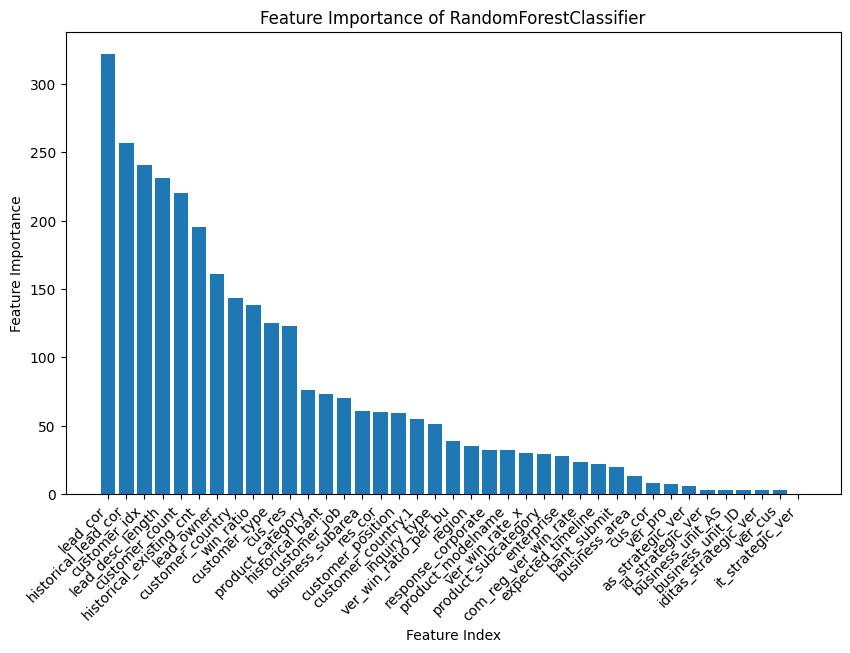

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = lgb.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

feature_names = x_train.columns

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(x_train.shape[1]), sorted_feature_importances, align='center')
plt.xticks(range(x_train.shape[1]),[x_train.columns[i] for i in sorted_indices], rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of RandomForestClassifier')
plt.show()

### threshold 확인

In [60]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)


In [61]:
import lightgbm as lgb
### LGBM model
lgb_params = {'reg_alpha': 1.7941020364544445e-05, 
              'reg_lambda': 0.08296868193333816, 
              'max_depth': 2, 
              'num_leaves': 51, 
              'colsample_bytree': 0.4271363733463229, 
              'subsample': 0.527731231534285, 
              'subsample_freq': 4, 
              'min_child_samples': 31, 
              'max_bin': 449
             }

model_lgbm = lgb.LGBMClassifier(scale_pos_weight=11, **lgb_params)

model_lgbm.fit(x_train, y_train)

# 예측 확률 계산
probas = model_lgbm.predict_proba(x_test)[:, 1] # Positive class에 대한 예측 확률만 사용합니다.


[LightGBM] [Info] Number of positive: 3903, number of negative: 43536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4679
[LightGBM] [Info] Number of data points in the train set: 47439, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082274 -> initscore=-2.411843
[LightGBM] [Info] Start training from score -2.411843


In [62]:
from sklearn.metrics import f1_score

# 여러 Threshold 값에 대해 예측 수행
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    preds = [1 if proba >= threshold else 0 for proba in probas]
    score = f1_score(y_test, preds)
    print(f'Threshold: {threshold}, F1 Score: {score}')


Threshold: 0.1, F1 Score: 0.7181437809052871
Threshold: 0.2, F1 Score: 0.7925801011804384
Threshold: 0.3, F1 Score: 0.8353413654618475
Threshold: 0.4, F1 Score: 0.8589802480477722
Threshold: 0.5, F1 Score: 0.8775413711583923
Threshold: 0.6, F1 Score: 0.89351403678606
Threshold: 0.7, F1 Score: 0.9107231920199502
Threshold: 0.8, F1 Score: 0.9226006191950464
Threshold: 0.9, F1 Score: 0.9210245464247598


In [63]:
x_test = df_test.drop(["is_converted",'id'], axis=1)

# 예측 확률 계산
probas_test = model_lgbm.predict_proba(x_test)[:, 1] # Positive class에 대한 예측 확률만 사용합니다.

# 최적의 Threshold 값인 0.9를 사용하여 예측 수행
test_pred = [1 if proba >= 0.8 else 0 for proba in probas_test]

# True로 예측된 개수
print(sum(test_pred))

1008


In [525]:
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [580]:
col = ['product_subcategory','product_modelname','customer_country', 'id_strategic_ver',
       'iditas_strategic_ver','as_strategic_ver', 'ver_cus', 'ver_pro', 'region',
      'com_reg_ver_win_rate', 'business_area']
#    'it_strategic_ver', 
drop_train = x_train.drop(col,axis=1)
drop_val = x_val.drop(col,axis=1)
drop_test = x_test.drop(col, axis=1)

In [581]:
import lightgbm as lgb

lgb_params = {'reg_alpha': 1.7941020364544445e-05, 
              'reg_lambda': 0.08296868193333816, 
              'max_depth': 2, 
              'num_leaves': 51, 
              'colsample_bytree': 0.4271363733463229, 
              'subsample': 0.527731231534285, 
              'subsample_freq': 4, 
              'min_child_samples': 31, 
              'max_bin': 449
             }

lgb = lgb.LGBMClassifier(scale_pos_weight=11, **lgb_params)
lgb.fit(drop_train.fillna(0), y_train)

pred = lgb.predict(drop_val.fillna(0))
get_clf_eval(y_val, pred)
# 제출 점수 0.3

[LightGBM] [Info] Number of positive: 3903, number of negative: 43536
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3759
[LightGBM] [Info] Number of data points in the train set: 47439, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.082274 -> initscore=-2.411843
[LightGBM] [Info] Start training from score -2.411843
오차행렬:
 [[  926    21]
 [  239 10674]]

정확도: 0.9781
정밀도: 0.7948
재현율: 0.9778
F1: 0.8769


In [582]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted",'id'], axis=1)


test_pred = lgb.predict(drop_test.fillna(0))
sum(test_pred) # True로 예측된 개수

# 9.2
# 0.7498
# 1396

# 11
# 0.7428
# 1447


# 
# 9.2
# 0.7644
# 1362

# 11
# 0.7628
# 1424
# F1 = 0.7034



1839

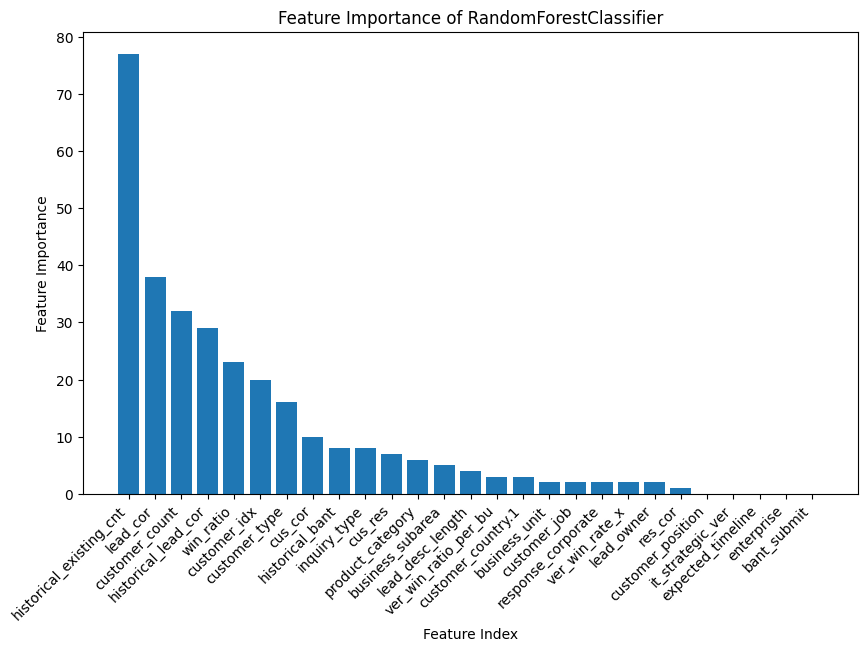

In [583]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = lgb.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

feature_names = drop_train.columns

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(drop_train.shape[1]), sorted_feature_importances, align='center')
plt.xticks(range(drop_train.shape[1]),[drop_train.columns[i] for i in sorted_indices], rotation=45, ha='right')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of RandomForestClassifier')
plt.show()

In [258]:
xgboost

(1) n_estimators / 학습횟수(100,200,300, ...)
- early stopping과 함께 사용하는 것이 좋다
- early_stopping_rounds = 50 / 각 fold별 iteration 수를 구한 후 평균값에 10%정도 큰 값을 사용하는 것이 좋음

(2) max_depth / 클수록 학습 데이터에 피팅이 잘됨
- xgb 디폴트값 0 / lgbm 디폴트값 -1 
- 그라디언트 부스팅에서 가장 민감함 파라미터
- 복잡도에 따라 필요한 깊이가 다르다. 너무 크면 오버피팅, 너무 작으면 언더피팅
- lgbm은 디폴트값(-1)로 설정하는 것이 보통 좋다. / xgb 깊이에 따른 성능이 다르다.
- 

(3) xgb :  max_leaves(255), lgbm :  num_leaves(31)
- 그라디언트 부스팅에서 두번째로 민감한 파라미터


(4) xgb : subsample(1) / lgbm : bagging_fraction(1)
- 그라디언트 부스팅에서 세번째로 민감한 파라미터
- 보통 0.7 사용

(5) xgb : colsample_bytree(1) / lgbm : feature_fraction(1)
- 그라디언트 부스팅에서 세번쨰로 민감한 파라미터
- 보통 0.3 사용




SyntaxError: invalid syntax (689759451.py, line 3)

In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import lightgbm as lgb

X = df_train.fillna(0)
X = X.drop(col,axis=1)
X = X.drop('is_converted', axis=1)
y = df_train['is_converted']

num_classes = len(y.unique())

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "binary",
        "metric": "binary_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    model = lgb.LGBMClassifier(scale_pos_weight=11, **params_lgb)
    
    # early stopping을 수행하기 위해 학습 데이터를 검증 데이터로 사용하여 직접 구현
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_metric='binary_logloss'  # 검증 데이터에 대한 평가 메트릭 설정
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred[:, 1])  # 이진 분류에서는 positive class의 확률을 사용
    return log_score


In [ ]:
# from lightgbm import LGBMClassifier
# sampler = TPESampler(seed=42)
# study = optuna.create_study(
#     study_name="lgbm_parameter_opt",
#     direction="minimize",
#     sampler=sampler,
# )
# study.optimize(lgb_objective, n_trials=10)
# print("Best Score:", study.best_value)
# print("Best trial:", study.best_trial.params)

# Best Score: 0.09332904645311418
# Best trial: {'reg_alpha': 1.7941020364544445e-05, 'reg_lambda': 0.08296868193333816, 'max_depth': 2, 'num_leaves': 51, 'colsample_bytree': 0.4271363733463229, 'subsample': 0.527731231534285, 'subsample_freq': 4, 'min_child_samples': 31, 'max_bin': 449}


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

def xgb_objective(trial):
    xgb_params = {
        "objective": "multi:softprob",
        "booster": "gbtree",
        "tree_method": "exact",
        "verbosity": 0,
        'num_class': 3,
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        'n_estimators': trial.suggest_int("n_estimators", 1000, 10000, step=100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBClassifier(scale_pos_weight=11,**xgb_params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
    )

    xgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, xgb_pred[:, 1])  # 양성 클래스의 확률만 사용
    return log_score


In [ ]:
# sampler = TPESampler(seed=42)
# study = optuna.create_study(
#     study_name="xgb_parameter_opt",
#     direction="minimize",
#     sampler=sampler,
# )
# study.optimize(xgb_objective, n_trials=10)
# print("Best Score:", study.best_value)
# print("Best trial:", study.best_trial.params)

# Best Score: 0.06480540007930741
# Best trial: {'max_depth': 10, 
#              'learning_rate': 0.08769872778119511, 
#              'n_estimators': 2700, 
#              'colsample_bytree': 0.522613644455269, 
#              'colsample_bylevel': 0.6626651653816322, 
#              'colsample_bynode': 0.6943386448447411, 
#              'reg_lambda': 0.03488976654890366, 
#              'reg_alpha': 0.4544383960336014, 
#              'subsample': 0.75, 
#              'min_child_weight': 5, 
#              'gamma': 0.3488960745139221}

In [ ]:
from catboost import CatBoostClassifier

def cat_objective(trial):

    params_cat = {
      "random_state":42,
      'learning_rate' : trial.suggest_uniform('learning_rate', 0.0002, 0.0003),
    } 

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


    model = CatBoostClassifier(scale_pos_weight=11,**params_cat)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    
    return log_score

In [ ]:
# from lightgbm import LGBMClassifier
# sampler = TPESampler(seed=42)
# study = optuna.create_study(
#     study_name="cat_parameter_opt",
#     direction="minimize",
#     sampler=sampler,
# )
# study.optimize(cat_objective, n_trials=10)
# print("Best Score:", study.best_value)
# print("Best trial:", study.best_trial.params)

# Best Score: 0.3672839487671902
# Best trial: {'learning_rate': 0.0002950714306409916}

In [ ]:
from sklearn.model_selection import cross_val_score

features = df_train.drop('is_converted',axis=1)
label = df_train['is_converted']



score = cross_val_score(lgb, features, label, scoring = 'f1_macro', cv=5)
print(f"단일 f1_macro : {score}")
print(f"5번의 fold 후 평균 f1_macro: {np.mean(score)}")

In [234]:
col = ['res_cor','cus_cor',
      'product_subcategory','product_modelname','customer_idx','lead_owner','customer_country.1']
#      'id_strategic_ver','it_strategic_ver','iditas_strategic_ver','as_strategic_ver'

In [181]:
def F1_score(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))
    
    return F1  # 평가 지표 반환



In [235]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import time
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 6, random_state = 42, shuffle = True) #총 6번의 fold 진행
n = 0 #x번째 fold인지 기록

fold_target_pred = []
fold_score = []

x_train = df_train.fillna(0)
data_train_X = x_train.drop(col,axis=1)
data_train_X = data_train_X.drop(['is_converted'],axis=1)
data_train_y = x_train['is_converted']
data_train_y = data_train_y.astype('int')

x_test = df_test.drop(["is_converted",'id'], axis=1)
x_test = x_test.fillna(0)
data_test = x_test.drop(col,axis=1)


for train_index, valid_index in skf.split(data_train_X, data_train_y): #label 기준으로 stratified k fold 진행
    n += 1
    
    val_pred_name = [] #validation pred model 이름 저장
    val_pred = []      #validation set pred 결과 저장
    target_pred = []   #test set pred 결과 저장
    
    train_X = np.array(data_train_X)
    label_Y = np.array(data_train_y) # label값만 가지는 데이터
    
    X_train, X_valid = train_X[train_index], train_X[valid_index]
    
    y_train, y_valid = label_Y[train_index], label_Y[valid_index]

    X_test = np.array(data_test)
    
    ### Create Model ###
    #CAT model
#     cat_params = {'learning_rate': 0.016149614799999188,
#              'bagging_temperature': 16.172900811143155,
#              'n_estimators': 1671, 
#              'max_depth': 16, 
#              'random_strength': 77,
#              'colsample_bylevel': 0.5192294089205034,
#              'l2_leaf_reg': 1.7560829253683595e-07,
#              'min_child_samples': 83, 
#              'max_bin': 412,
#              'od_type': 'Iter'}
    start_time_cat = time.time()
    model_cat = CatBoostClassifier(scale_pos_weight=11) # **cat_params
    
    model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    end_time_cat = time.time()
    
    
    val_pred_name.append("CatBoostClassifier")  # 모델 이름 저장
    val_pred.append(model_cat.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model_cat.predict(X_test)) # test set pred 결과 저장
    
    ### LGBM model
#     lgb_params = {'reg_alpha': 1.7941020364544445e-05, 
#                   'reg_lambda': 0.08296868193333816, 
#                   'max_depth': 2, 
#                   'num_leaves': 51, 
#                   'colsample_bytree': 0.4271363733463229, 
#                   'subsample': 0.527731231534285, 
#                   'subsample_freq': 4, 
#                   'min_child_samples': 31, 
#                   'max_bin': 449
#                  }

    start_time_lgb = time.time()
    model_lgbm = lgb.LGBMClassifier(scale_pos_weight=11) #**lgb_params
    
    model_lgbm.fit(X_train, y_train)
    end_time_lgb = time.time()
    val_pred_name.append("LGBMClassifier")  # 모델 이름 저장
    val_pred.append(model_lgbm.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model_lgbm.predict(X_test)) # test set pred 결과 저장
    
    ### XGB model
#     xgb_params = {'max_depth': 10, 
#              'learning_rate': 0.08769872778119511, 
#              'n_estimators': 2700, 
#              'colsample_bytree': 0.522613644455269, 
#              'colsample_bylevel': 0.6626651653816322, 
#              'colsample_bynode': 0.6943386448447411, 
#              'reg_lambda': 0.03488976654890366, 
#              'reg_alpha': 0.4544383960336014, 
#              'subsample': 0.75, 
#              'min_child_weight': 5, 
#              'gamma': 0.3488960745139221}
    start_time_xgb = time.time()
    model_xgb = XGBClassifier(scale_pos_weight=11) #**xgb_params
    
    model_xgb.fit(X_train, y_train)
    end_time_xgb = time.time()
    val_pred_name.append("XGBClassifier")  # 모델 이름 저장
    val_pred.append(model_xgb.predict(X_valid))   # validation set pred 결과 저장
    target_pred.append(model_xgb.predict(X_test)) # test set pred 결과 저장
    

    ### average validation pred ###
    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i]
    preds = preds/len(val_pred)

    ### average target pred ###
    target_preds = target_pred[0]
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i]
    target_preds = target_preds/len(target_pred)
    fold_target_pred.append(target_preds) # append final target pred
    
    print("========== fold %d ==========" %(n))
    for i in range(len(val_pred)):
        print("%s model F1-score : %0.4f" %(val_pred_name[i], F1_score(y_valid, val_pred[i].astype(int))))
        
    print('CAT 코드 실행 시간: %10ds' % (end_time_cat - start_time_cat))
    print('LGB 코드 실행 시간: %10ds' % (end_time_lgb - start_time_lgb))
    print('XGB 코드 실행 시간: %10ds' % (end_time_xgb - start_time_xgb))
    print("average model F1-score : %0.4f" %(F1_score(y_valid, preds.astype(int))))
    fold_score.append(F1_score(y_valid, preds.astype(int)))

total_score = fold_score[0]
for i in range(1, len(fold_score)):
    total_score += fold_score[i]
    
total_score = total_score/len(fold_score)

print("==============================")
print("Model Sum Average F1_score %0.4f" %(total_score))

Learning rate set to 0.083041
0:	learn: 0.5416178	test: 0.5407409	best: 0.5407409 (0)	total: 14.9ms	remaining: 14.8s
1:	learn: 0.4144199	test: 0.4126538	best: 0.4126538 (1)	total: 27.9ms	remaining: 13.9s
2:	learn: 0.3232718	test: 0.3223151	best: 0.3223151 (2)	total: 40.4ms	remaining: 13.4s
3:	learn: 0.2550811	test: 0.2537459	best: 0.2537459 (3)	total: 52.3ms	remaining: 13s
4:	learn: 0.2033947	test: 0.2016754	best: 0.2016754 (4)	total: 63.4ms	remaining: 12.6s
5:	learn: 0.1762161	test: 0.1749721	best: 0.1749721 (5)	total: 74.4ms	remaining: 12.3s
6:	learn: 0.1523120	test: 0.1511371	best: 0.1511371 (6)	total: 85.4ms	remaining: 12.1s
7:	learn: 0.1327767	test: 0.1317117	best: 0.1317117 (7)	total: 96.7ms	remaining: 12s
8:	learn: 0.1136715	test: 0.1125535	best: 0.1125535 (8)	total: 108ms	remaining: 11.9s
9:	learn: 0.0990125	test: 0.0975585	best: 0.0975585 (9)	total: 119ms	remaining: 11.8s
10:	learn: 0.0898541	test: 0.0880969	best: 0.0880969 (10)	total: 130ms	remaining: 11.7s
11:	learn: 0.08254

112:	learn: 0.0300653	test: 0.0385283	best: 0.0385283 (112)	total: 1.22s	remaining: 9.57s
113:	learn: 0.0299250	test: 0.0384943	best: 0.0384943 (113)	total: 1.23s	remaining: 9.57s
114:	learn: 0.0297814	test: 0.0385056	best: 0.0384943 (113)	total: 1.24s	remaining: 9.56s
115:	learn: 0.0296726	test: 0.0384614	best: 0.0384614 (115)	total: 1.25s	remaining: 9.54s
116:	learn: 0.0295816	test: 0.0383400	best: 0.0383400 (116)	total: 1.26s	remaining: 9.53s
117:	learn: 0.0294570	test: 0.0383204	best: 0.0383204 (117)	total: 1.27s	remaining: 9.52s
118:	learn: 0.0293684	test: 0.0383475	best: 0.0383204 (117)	total: 1.28s	remaining: 9.5s
119:	learn: 0.0292793	test: 0.0382841	best: 0.0382841 (119)	total: 1.29s	remaining: 9.48s
120:	learn: 0.0290572	test: 0.0380929	best: 0.0380929 (120)	total: 1.3s	remaining: 9.48s
121:	learn: 0.0289756	test: 0.0379973	best: 0.0379973 (121)	total: 1.31s	remaining: 9.46s
122:	learn: 0.0289026	test: 0.0379443	best: 0.0379443 (122)	total: 1.32s	remaining: 9.44s
123:	learn: 

212:	learn: 0.0215218	test: 0.0381239	best: 0.0375080 (190)	total: 2.25s	remaining: 8.31s
213:	learn: 0.0214623	test: 0.0382192	best: 0.0375080 (190)	total: 2.26s	remaining: 8.29s
214:	learn: 0.0212813	test: 0.0381528	best: 0.0375080 (190)	total: 2.27s	remaining: 8.27s
215:	learn: 0.0212452	test: 0.0381447	best: 0.0375080 (190)	total: 2.27s	remaining: 8.26s
216:	learn: 0.0212227	test: 0.0381102	best: 0.0375080 (190)	total: 2.28s	remaining: 8.24s
217:	learn: 0.0211602	test: 0.0381063	best: 0.0375080 (190)	total: 2.29s	remaining: 8.23s
218:	learn: 0.0211132	test: 0.0380708	best: 0.0375080 (190)	total: 2.3s	remaining: 8.21s
219:	learn: 0.0210593	test: 0.0381101	best: 0.0375080 (190)	total: 2.31s	remaining: 8.2s
220:	learn: 0.0210261	test: 0.0380983	best: 0.0375080 (190)	total: 2.32s	remaining: 8.18s
221:	learn: 0.0209510	test: 0.0380797	best: 0.0375080 (190)	total: 2.33s	remaining: 8.16s
222:	learn: 0.0209269	test: 0.0380584	best: 0.0375080 (190)	total: 2.34s	remaining: 8.15s
223:	learn: 

312:	learn: 0.0169488	test: 0.0386765	best: 0.0375080 (190)	total: 3.06s	remaining: 6.73s
313:	learn: 0.0168749	test: 0.0386985	best: 0.0375080 (190)	total: 3.07s	remaining: 6.71s
314:	learn: 0.0168539	test: 0.0386702	best: 0.0375080 (190)	total: 3.08s	remaining: 6.7s
315:	learn: 0.0168050	test: 0.0386435	best: 0.0375080 (190)	total: 3.08s	remaining: 6.68s
316:	learn: 0.0167559	test: 0.0386100	best: 0.0375080 (190)	total: 3.09s	remaining: 6.66s
317:	learn: 0.0166911	test: 0.0386378	best: 0.0375080 (190)	total: 3.1s	remaining: 6.65s
318:	learn: 0.0166709	test: 0.0386341	best: 0.0375080 (190)	total: 3.11s	remaining: 6.63s
319:	learn: 0.0166557	test: 0.0387094	best: 0.0375080 (190)	total: 3.11s	remaining: 6.62s
320:	learn: 0.0165904	test: 0.0387188	best: 0.0375080 (190)	total: 3.12s	remaining: 6.6s
321:	learn: 0.0165481	test: 0.0387088	best: 0.0375080 (190)	total: 3.13s	remaining: 6.58s
322:	learn: 0.0164905	test: 0.0387856	best: 0.0375080 (190)	total: 3.13s	remaining: 6.57s
323:	learn: 0

404:	learn: 0.0145967	test: 0.0386964	best: 0.0375080 (190)	total: 3.67s	remaining: 5.4s
405:	learn: 0.0145748	test: 0.0386593	best: 0.0375080 (190)	total: 3.68s	remaining: 5.38s
406:	learn: 0.0145356	test: 0.0386723	best: 0.0375080 (190)	total: 3.69s	remaining: 5.37s
407:	learn: 0.0145129	test: 0.0386222	best: 0.0375080 (190)	total: 3.69s	remaining: 5.36s
408:	learn: 0.0144986	test: 0.0386242	best: 0.0375080 (190)	total: 3.7s	remaining: 5.35s
409:	learn: 0.0144632	test: 0.0386562	best: 0.0375080 (190)	total: 3.71s	remaining: 5.33s
410:	learn: 0.0144414	test: 0.0386464	best: 0.0375080 (190)	total: 3.71s	remaining: 5.32s
411:	learn: 0.0144112	test: 0.0387343	best: 0.0375080 (190)	total: 3.72s	remaining: 5.31s
412:	learn: 0.0143974	test: 0.0387159	best: 0.0375080 (190)	total: 3.73s	remaining: 5.3s
413:	learn: 0.0143566	test: 0.0387304	best: 0.0375080 (190)	total: 3.73s	remaining: 5.29s
414:	learn: 0.0143497	test: 0.0387236	best: 0.0375080 (190)	total: 3.74s	remaining: 5.27s
415:	learn: 0

527:	learn: 0.0120281	test: 0.0393607	best: 0.0375080 (190)	total: 4.49s	remaining: 4.01s
528:	learn: 0.0120281	test: 0.0393607	best: 0.0375080 (190)	total: 4.49s	remaining: 4s
529:	learn: 0.0120281	test: 0.0393607	best: 0.0375080 (190)	total: 4.5s	remaining: 3.99s
530:	learn: 0.0120281	test: 0.0393607	best: 0.0375080 (190)	total: 4.5s	remaining: 3.98s
531:	learn: 0.0120281	test: 0.0393607	best: 0.0375080 (190)	total: 4.51s	remaining: 3.96s
532:	learn: 0.0120280	test: 0.0393607	best: 0.0375080 (190)	total: 4.51s	remaining: 3.95s
533:	learn: 0.0120280	test: 0.0393607	best: 0.0375080 (190)	total: 4.52s	remaining: 3.94s
534:	learn: 0.0120054	test: 0.0393645	best: 0.0375080 (190)	total: 4.52s	remaining: 3.93s
535:	learn: 0.0119920	test: 0.0393314	best: 0.0375080 (190)	total: 4.53s	remaining: 3.92s
536:	learn: 0.0119563	test: 0.0393194	best: 0.0375080 (190)	total: 4.54s	remaining: 3.91s
537:	learn: 0.0119563	test: 0.0393195	best: 0.0375080 (190)	total: 4.54s	remaining: 3.9s
538:	learn: 0.01

621:	learn: 0.0108359	test: 0.0403066	best: 0.0375080 (190)	total: 5.09s	remaining: 3.09s
622:	learn: 0.0108359	test: 0.0403051	best: 0.0375080 (190)	total: 5.09s	remaining: 3.08s
623:	learn: 0.0108358	test: 0.0403043	best: 0.0375080 (190)	total: 5.1s	remaining: 3.07s
624:	learn: 0.0108358	test: 0.0403035	best: 0.0375080 (190)	total: 5.1s	remaining: 3.06s
625:	learn: 0.0108358	test: 0.0403028	best: 0.0375080 (190)	total: 5.11s	remaining: 3.05s
626:	learn: 0.0108358	test: 0.0403020	best: 0.0375080 (190)	total: 5.11s	remaining: 3.04s
627:	learn: 0.0108357	test: 0.0403012	best: 0.0375080 (190)	total: 5.12s	remaining: 3.03s
628:	learn: 0.0108357	test: 0.0403008	best: 0.0375080 (190)	total: 5.13s	remaining: 3.02s
629:	learn: 0.0108357	test: 0.0403008	best: 0.0375080 (190)	total: 5.13s	remaining: 3.01s
630:	learn: 0.0108357	test: 0.0403006	best: 0.0375080 (190)	total: 5.14s	remaining: 3s
631:	learn: 0.0108357	test: 0.0403004	best: 0.0375080 (190)	total: 5.14s	remaining: 2.99s
632:	learn: 0.0

726:	learn: 0.0108284	test: 0.0403213	best: 0.0375080 (190)	total: 5.69s	remaining: 2.14s
727:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.7s	remaining: 2.13s
728:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.7s	remaining: 2.12s
729:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.71s	remaining: 2.11s
730:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.71s	remaining: 2.1s
731:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.72s	remaining: 2.09s
732:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.72s	remaining: 2.08s
733:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.73s	remaining: 2.08s
734:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.74s	remaining: 2.07s
735:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.74s	remaining: 2.06s
736:	learn: 0.0108283	test: 0.0403211	best: 0.0375080 (190)	total: 5.75s	remaining: 2.05s
737:	learn: 0

836:	learn: 0.0105426	test: 0.0405369	best: 0.0375080 (190)	total: 6.3s	remaining: 1.23s
837:	learn: 0.0105426	test: 0.0405369	best: 0.0375080 (190)	total: 6.3s	remaining: 1.22s
838:	learn: 0.0105426	test: 0.0405369	best: 0.0375080 (190)	total: 6.31s	remaining: 1.21s
839:	learn: 0.0105426	test: 0.0405369	best: 0.0375080 (190)	total: 6.32s	remaining: 1.2s
840:	learn: 0.0105426	test: 0.0405369	best: 0.0375080 (190)	total: 6.32s	remaining: 1.19s
841:	learn: 0.0105425	test: 0.0405377	best: 0.0375080 (190)	total: 6.33s	remaining: 1.19s
842:	learn: 0.0105425	test: 0.0405377	best: 0.0375080 (190)	total: 6.33s	remaining: 1.18s
843:	learn: 0.0105425	test: 0.0405377	best: 0.0375080 (190)	total: 6.33s	remaining: 1.17s
844:	learn: 0.0105425	test: 0.0405377	best: 0.0375080 (190)	total: 6.34s	remaining: 1.16s
845:	learn: 0.0105425	test: 0.0405377	best: 0.0375080 (190)	total: 6.34s	remaining: 1.16s
846:	learn: 0.0105425	test: 0.0405378	best: 0.0375080 (190)	total: 6.35s	remaining: 1.15s
847:	learn: 0

952:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.91s	remaining: 341ms
953:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.91s	remaining: 333ms
954:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.92s	remaining: 326ms
955:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.92s	remaining: 319ms
956:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.93s	remaining: 311ms
957:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.93s	remaining: 304ms
958:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.94s	remaining: 297ms
959:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.94s	remaining: 289ms
960:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.95s	remaining: 282ms
961:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.95s	remaining: 275ms
962:	learn: 0.0104742	test: 0.0405846	best: 0.0375080 (190)	total: 6.96s	remaining: 267ms
963:	learn

54:	learn: 0.0396393	test: 0.0408279	best: 0.0408279 (54)	total: 401ms	remaining: 6.89s
55:	learn: 0.0391264	test: 0.0405121	best: 0.0405121 (55)	total: 408ms	remaining: 6.88s
56:	learn: 0.0389865	test: 0.0404751	best: 0.0404751 (56)	total: 415ms	remaining: 6.86s
57:	learn: 0.0386250	test: 0.0403295	best: 0.0403295 (57)	total: 422ms	remaining: 6.85s
58:	learn: 0.0384013	test: 0.0402469	best: 0.0402469 (58)	total: 429ms	remaining: 6.84s
59:	learn: 0.0382067	test: 0.0400086	best: 0.0400086 (59)	total: 436ms	remaining: 6.83s
60:	learn: 0.0378320	test: 0.0397214	best: 0.0397214 (60)	total: 443ms	remaining: 6.82s
61:	learn: 0.0375541	test: 0.0395497	best: 0.0395497 (61)	total: 451ms	remaining: 6.82s
62:	learn: 0.0370578	test: 0.0389319	best: 0.0389319 (62)	total: 458ms	remaining: 6.81s
63:	learn: 0.0369128	test: 0.0389209	best: 0.0389209 (63)	total: 464ms	remaining: 6.79s
64:	learn: 0.0367614	test: 0.0388283	best: 0.0388283 (64)	total: 472ms	remaining: 6.78s
65:	learn: 0.0365424	test: 0.038

172:	learn: 0.0241064	test: 0.0333427	best: 0.0333427 (172)	total: 1.21s	remaining: 5.81s
173:	learn: 0.0240104	test: 0.0333316	best: 0.0333316 (173)	total: 1.22s	remaining: 5.8s
174:	learn: 0.0239477	test: 0.0334177	best: 0.0333316 (173)	total: 1.23s	remaining: 5.79s
175:	learn: 0.0239285	test: 0.0334304	best: 0.0333316 (173)	total: 1.23s	remaining: 5.78s
176:	learn: 0.0238181	test: 0.0334479	best: 0.0333316 (173)	total: 1.24s	remaining: 5.77s
177:	learn: 0.0237917	test: 0.0334453	best: 0.0333316 (173)	total: 1.25s	remaining: 5.76s
178:	learn: 0.0237310	test: 0.0334531	best: 0.0333316 (173)	total: 1.25s	remaining: 5.75s
179:	learn: 0.0236496	test: 0.0334275	best: 0.0333316 (173)	total: 1.26s	remaining: 5.75s
180:	learn: 0.0236307	test: 0.0333931	best: 0.0333316 (173)	total: 1.27s	remaining: 5.74s
181:	learn: 0.0235737	test: 0.0333519	best: 0.0333316 (173)	total: 1.27s	remaining: 5.73s
182:	learn: 0.0234272	test: 0.0331985	best: 0.0331985 (182)	total: 1.28s	remaining: 5.72s
183:	learn:

292:	learn: 0.0177618	test: 0.0317776	best: 0.0317776 (292)	total: 2.04s	remaining: 4.91s
293:	learn: 0.0177248	test: 0.0317749	best: 0.0317749 (293)	total: 2.04s	remaining: 4.91s
294:	learn: 0.0176211	test: 0.0317157	best: 0.0317157 (294)	total: 2.05s	remaining: 4.9s
295:	learn: 0.0175838	test: 0.0317223	best: 0.0317157 (294)	total: 2.06s	remaining: 4.89s
296:	learn: 0.0175736	test: 0.0317520	best: 0.0317157 (294)	total: 2.06s	remaining: 4.88s
297:	learn: 0.0175331	test: 0.0318179	best: 0.0317157 (294)	total: 2.07s	remaining: 4.88s
298:	learn: 0.0174728	test: 0.0318155	best: 0.0317157 (294)	total: 2.08s	remaining: 4.87s
299:	learn: 0.0174601	test: 0.0318612	best: 0.0317157 (294)	total: 2.08s	remaining: 4.86s
300:	learn: 0.0174512	test: 0.0318622	best: 0.0317157 (294)	total: 2.09s	remaining: 4.85s
301:	learn: 0.0173856	test: 0.0319041	best: 0.0317157 (294)	total: 2.1s	remaining: 4.84s
302:	learn: 0.0173333	test: 0.0319020	best: 0.0317157 (294)	total: 2.1s	remaining: 4.84s
303:	learn: 0

415:	learn: 0.0143051	test: 0.0323238	best: 0.0317157 (294)	total: 2.85s	remaining: 4s
416:	learn: 0.0143051	test: 0.0323239	best: 0.0317157 (294)	total: 2.85s	remaining: 3.99s
417:	learn: 0.0142707	test: 0.0323437	best: 0.0317157 (294)	total: 2.86s	remaining: 3.98s
418:	learn: 0.0142247	test: 0.0323977	best: 0.0317157 (294)	total: 2.87s	remaining: 3.98s
419:	learn: 0.0142247	test: 0.0323977	best: 0.0317157 (294)	total: 2.87s	remaining: 3.97s
420:	learn: 0.0142247	test: 0.0323978	best: 0.0317157 (294)	total: 2.88s	remaining: 3.96s
421:	learn: 0.0142247	test: 0.0323979	best: 0.0317157 (294)	total: 2.88s	remaining: 3.95s
422:	learn: 0.0142247	test: 0.0323980	best: 0.0317157 (294)	total: 2.89s	remaining: 3.94s
423:	learn: 0.0142246	test: 0.0323992	best: 0.0317157 (294)	total: 2.89s	remaining: 3.93s
424:	learn: 0.0142245	test: 0.0323995	best: 0.0317157 (294)	total: 2.9s	remaining: 3.92s
425:	learn: 0.0142245	test: 0.0324002	best: 0.0317157 (294)	total: 2.9s	remaining: 3.91s
426:	learn: 0.0

522:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.45s	remaining: 3.14s
523:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.45s	remaining: 3.14s
524:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.46s	remaining: 3.13s
525:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.46s	remaining: 3.12s
526:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.47s	remaining: 3.11s
527:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.48s	remaining: 3.11s
528:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.48s	remaining: 3.1s
529:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.49s	remaining: 3.09s
530:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.49s	remaining: 3.08s
531:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.5s	remaining: 3.08s
532:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 3.5s	remaining: 3.07s
533:	learn: 0

633:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.06s	remaining: 2.34s
634:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.06s	remaining: 2.34s
635:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.07s	remaining: 2.33s
636:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.08s	remaining: 2.32s
637:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.08s	remaining: 2.31s
638:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.09s	remaining: 2.31s
639:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.09s	remaining: 2.3s
640:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.1s	remaining: 2.29s
641:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.1s	remaining: 2.29s
642:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.11s	remaining: 2.28s
643:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.11s	remaining: 2.27s
644:	learn: 0

742:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.66s	remaining: 1.61s
743:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.67s	remaining: 1.61s
744:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.67s	remaining: 1.6s
745:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.68s	remaining: 1.59s
746:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.68s	remaining: 1.59s
747:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.69s	remaining: 1.58s
748:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.7s	remaining: 1.57s
749:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.7s	remaining: 1.57s
750:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.71s	remaining: 1.56s
751:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.71s	remaining: 1.55s
752:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 4.72s	remaining: 1.55s
753:	learn: 0

851:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.26s	remaining: 914ms
852:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.27s	remaining: 908ms
853:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.27s	remaining: 902ms
854:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.28s	remaining: 895ms
855:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.29s	remaining: 889ms
856:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.29s	remaining: 883ms
857:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.3s	remaining: 877ms
858:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.3s	remaining: 870ms
859:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.31s	remaining: 864ms
860:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.31s	remaining: 858ms
861:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.32s	remaining: 851ms
862:	learn: 

960:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.86s	remaining: 238ms
961:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.87s	remaining: 232ms
962:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.88s	remaining: 226ms
963:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.88s	remaining: 220ms
964:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.89s	remaining: 213ms
965:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.89s	remaining: 207ms
966:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.9s	remaining: 201ms
967:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.9s	remaining: 195ms
968:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.91s	remaining: 189ms
969:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.91s	remaining: 183ms
970:	learn: 0.0141735	test: 0.0323657	best: 0.0317157 (294)	total: 5.92s	remaining: 177ms
971:	learn: 

54:	learn: 0.0374379	test: 0.0464808	best: 0.0464808 (54)	total: 400ms	remaining: 6.88s
55:	learn: 0.0369756	test: 0.0461082	best: 0.0461082 (55)	total: 407ms	remaining: 6.87s
56:	learn: 0.0368061	test: 0.0460488	best: 0.0460488 (56)	total: 414ms	remaining: 6.85s
57:	learn: 0.0364399	test: 0.0459724	best: 0.0459724 (57)	total: 421ms	remaining: 6.84s
58:	learn: 0.0361184	test: 0.0460020	best: 0.0459724 (57)	total: 428ms	remaining: 6.83s
59:	learn: 0.0359162	test: 0.0457999	best: 0.0457999 (59)	total: 435ms	remaining: 6.81s
60:	learn: 0.0357627	test: 0.0457561	best: 0.0457561 (60)	total: 442ms	remaining: 6.8s
61:	learn: 0.0355389	test: 0.0456706	best: 0.0456706 (61)	total: 449ms	remaining: 6.79s
62:	learn: 0.0352645	test: 0.0455556	best: 0.0455556 (62)	total: 456ms	remaining: 6.79s
63:	learn: 0.0348908	test: 0.0453556	best: 0.0453556 (63)	total: 464ms	remaining: 6.78s
64:	learn: 0.0345314	test: 0.0452919	best: 0.0452919 (64)	total: 471ms	remaining: 6.77s
65:	learn: 0.0343799	test: 0.0451

171:	learn: 0.0231334	test: 0.0392433	best: 0.0392433 (171)	total: 1.21s	remaining: 5.8s
172:	learn: 0.0230446	test: 0.0392190	best: 0.0392190 (172)	total: 1.21s	remaining: 5.8s
173:	learn: 0.0229958	test: 0.0393564	best: 0.0392190 (172)	total: 1.22s	remaining: 5.79s
174:	learn: 0.0229280	test: 0.0393257	best: 0.0392190 (172)	total: 1.23s	remaining: 5.78s
175:	learn: 0.0228669	test: 0.0394220	best: 0.0392190 (172)	total: 1.23s	remaining: 5.77s
176:	learn: 0.0228346	test: 0.0393876	best: 0.0392190 (172)	total: 1.24s	remaining: 5.76s
177:	learn: 0.0227063	test: 0.0391056	best: 0.0391056 (177)	total: 1.25s	remaining: 5.75s
178:	learn: 0.0226562	test: 0.0390673	best: 0.0390673 (178)	total: 1.25s	remaining: 5.75s
179:	learn: 0.0225649	test: 0.0390628	best: 0.0390628 (179)	total: 1.26s	remaining: 5.74s
180:	learn: 0.0225247	test: 0.0389899	best: 0.0389899 (180)	total: 1.27s	remaining: 5.73s
181:	learn: 0.0223783	test: 0.0390087	best: 0.0389899 (180)	total: 1.27s	remaining: 5.72s
182:	learn: 

293:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.02s	remaining: 4.84s
294:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.02s	remaining: 4.83s
295:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.03s	remaining: 4.82s
296:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.03s	remaining: 4.81s
297:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.04s	remaining: 4.8s
298:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.04s	remaining: 4.78s
299:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.04s	remaining: 4.77s
300:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.05s	remaining: 4.76s
301:	learn: 0.0171444	test: 0.0371507	best: 0.0371411 (280)	total: 2.06s	remaining: 4.75s
302:	learn: 0.0171443	test: 0.0371515	best: 0.0371411 (280)	total: 2.06s	remaining: 4.74s
303:	learn: 0.0171443	test: 0.0371515	best: 0.0371411 (280)	total: 2.07s	remaining: 4.73s
304:	learn:

410:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.62s	remaining: 3.75s
411:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.62s	remaining: 3.75s
412:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.63s	remaining: 3.74s
413:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.63s	remaining: 3.73s
414:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.64s	remaining: 3.72s
415:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.64s	remaining: 3.71s
416:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.65s	remaining: 3.7s
417:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.65s	remaining: 3.69s
418:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.66s	remaining: 3.69s
419:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.66s	remaining: 3.68s
420:	learn: 0.0170384	test: 0.0371210	best: 0.0370874 (374)	total: 2.67s	remaining: 3.67s
421:	learn:

525:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.22s	remaining: 2.9s
526:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.23s	remaining: 2.9s
527:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.23s	remaining: 2.89s
528:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.24s	remaining: 2.88s
529:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.24s	remaining: 2.88s
530:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.25s	remaining: 2.87s
531:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.25s	remaining: 2.86s
532:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.26s	remaining: 2.85s
533:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.26s	remaining: 2.85s
534:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.27s	remaining: 2.84s
535:	learn: 0.0166740	test: 0.0370476	best: 0.0369902 (520)	total: 3.27s	remaining: 2.83s
536:	learn: 

645:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.83s	remaining: 2.1s
646:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.83s	remaining: 2.09s
647:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.84s	remaining: 2.08s
648:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.84s	remaining: 2.08s
649:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.85s	remaining: 2.07s
650:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.85s	remaining: 2.07s
651:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.86s	remaining: 2.06s
652:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.87s	remaining: 2.05s
653:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.87s	remaining: 2.05s
654:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.87s	remaining: 2.04s
655:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 3.88s	remaining: 2.03s
656:	learn:

766:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.43s	remaining: 1.35s
767:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.44s	remaining: 1.34s
768:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.44s	remaining: 1.33s
769:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.45s	remaining: 1.33s
770:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.45s	remaining: 1.32s
771:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.46s	remaining: 1.32s
772:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.46s	remaining: 1.31s
773:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.47s	remaining: 1.3s
774:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.47s	remaining: 1.3s
775:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.48s	remaining: 1.29s
776:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 4.48s	remaining: 1.29s
777:	learn: 

887:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.04s	remaining: 635ms
888:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.04s	remaining: 630ms
889:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.05s	remaining: 624ms
890:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.05s	remaining: 618ms
891:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.06s	remaining: 612ms
892:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.06s	remaining: 607ms
893:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.07s	remaining: 601ms
894:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.07s	remaining: 595ms
895:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.08s	remaining: 589ms
896:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.08s	remaining: 583ms
897:	learn: 0.0165804	test: 0.0370963	best: 0.0369902 (520)	total: 5.09s	remaining: 578ms
898:	learn

[LightGBM] [Info] Number of positive: 4042, number of negative: 45374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2478
[LightGBM] [Info] Number of data points in the train set: 49416, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081795 -> initscore=-2.418200
[LightGBM] [Info] Start training from score -2.418200
========== fold 3 ==========
오차행렬:
 [[ 794   14]
 [ 105 8970]]

정확도: 0.9880
정밀도: 0.8832
재현율: 0.9827
F1: 0.9303
CatBoostClassifier model F1-score : 0.9303
오차행렬:
 [[ 792   16]
 [  88 8987]]

정확도: 0.9895
정밀도: 0.9000
재현율: 0.9802
F1: 0.9384
LGBMClassifier model F1-score : 0.9384
오차행렬:
 [[ 786   22]
 [  64 9011]]

정확도: 0.9913
정밀도: 0.9247
재현율: 0.9728
F1: 0.9481
XGBClassifier model F1-score : 0.9481
CAT 코드 실행 시간:          6s
LGB 코드 실행 시간:         

83:	learn: 0.0324075	test: 0.0424933	best: 0.0424933 (83)	total: 606ms	remaining: 6.61s
84:	learn: 0.0322961	test: 0.0424246	best: 0.0424246 (84)	total: 613ms	remaining: 6.6s
85:	learn: 0.0321998	test: 0.0422744	best: 0.0422744 (85)	total: 620ms	remaining: 6.59s
86:	learn: 0.0320498	test: 0.0420512	best: 0.0420512 (86)	total: 627ms	remaining: 6.58s
87:	learn: 0.0318443	test: 0.0419643	best: 0.0419643 (87)	total: 635ms	remaining: 6.58s
88:	learn: 0.0317281	test: 0.0419154	best: 0.0419154 (88)	total: 641ms	remaining: 6.56s
89:	learn: 0.0316312	test: 0.0419008	best: 0.0419008 (89)	total: 648ms	remaining: 6.55s
90:	learn: 0.0314516	test: 0.0417648	best: 0.0417648 (90)	total: 655ms	remaining: 6.55s
91:	learn: 0.0313991	test: 0.0417011	best: 0.0417011 (91)	total: 662ms	remaining: 6.53s
92:	learn: 0.0313029	test: 0.0415758	best: 0.0415758 (92)	total: 669ms	remaining: 6.52s
93:	learn: 0.0312575	test: 0.0415819	best: 0.0415758 (92)	total: 675ms	remaining: 6.51s
94:	learn: 0.0311026	test: 0.0414

200:	learn: 0.0215061	test: 0.0386701	best: 0.0386701 (200)	total: 1.42s	remaining: 5.64s
201:	learn: 0.0214816	test: 0.0386436	best: 0.0386436 (201)	total: 1.43s	remaining: 5.63s
202:	learn: 0.0214282	test: 0.0386261	best: 0.0386261 (202)	total: 1.43s	remaining: 5.62s
203:	learn: 0.0213256	test: 0.0386000	best: 0.0386000 (203)	total: 1.44s	remaining: 5.62s
204:	learn: 0.0212897	test: 0.0385889	best: 0.0385889 (204)	total: 1.45s	remaining: 5.61s
205:	learn: 0.0212563	test: 0.0385722	best: 0.0385722 (205)	total: 1.45s	remaining: 5.6s
206:	learn: 0.0211663	test: 0.0386443	best: 0.0385722 (205)	total: 1.46s	remaining: 5.59s
207:	learn: 0.0211463	test: 0.0386367	best: 0.0385722 (205)	total: 1.47s	remaining: 5.58s
208:	learn: 0.0210518	test: 0.0386512	best: 0.0385722 (205)	total: 1.47s	remaining: 5.57s
209:	learn: 0.0210084	test: 0.0385709	best: 0.0385709 (209)	total: 1.48s	remaining: 5.56s
210:	learn: 0.0209754	test: 0.0386259	best: 0.0385709 (209)	total: 1.49s	remaining: 5.56s
211:	learn:

317:	learn: 0.0158709	test: 0.0390610	best: 0.0384183 (225)	total: 2.23s	remaining: 4.77s
318:	learn: 0.0158431	test: 0.0391196	best: 0.0384183 (225)	total: 2.23s	remaining: 4.77s
319:	learn: 0.0158073	test: 0.0391257	best: 0.0384183 (225)	total: 2.24s	remaining: 4.76s
320:	learn: 0.0157904	test: 0.0391047	best: 0.0384183 (225)	total: 2.25s	remaining: 4.75s
321:	learn: 0.0157427	test: 0.0390676	best: 0.0384183 (225)	total: 2.25s	remaining: 4.74s
322:	learn: 0.0157216	test: 0.0390878	best: 0.0384183 (225)	total: 2.26s	remaining: 4.74s
323:	learn: 0.0156891	test: 0.0390699	best: 0.0384183 (225)	total: 2.27s	remaining: 4.73s
324:	learn: 0.0156890	test: 0.0390717	best: 0.0384183 (225)	total: 2.27s	remaining: 4.72s
325:	learn: 0.0156628	test: 0.0390415	best: 0.0384183 (225)	total: 2.28s	remaining: 4.71s
326:	learn: 0.0156306	test: 0.0390298	best: 0.0384183 (225)	total: 2.29s	remaining: 4.7s
327:	learn: 0.0155644	test: 0.0391026	best: 0.0384183 (225)	total: 2.29s	remaining: 4.7s
328:	learn: 

444:	learn: 0.0131332	test: 0.0406170	best: 0.0384183 (225)	total: 3.03s	remaining: 3.78s
445:	learn: 0.0131332	test: 0.0406169	best: 0.0384183 (225)	total: 3.04s	remaining: 3.77s
446:	learn: 0.0131332	test: 0.0406169	best: 0.0384183 (225)	total: 3.04s	remaining: 3.76s
447:	learn: 0.0131332	test: 0.0406168	best: 0.0384183 (225)	total: 3.05s	remaining: 3.75s
448:	learn: 0.0131332	test: 0.0406168	best: 0.0384183 (225)	total: 3.05s	remaining: 3.74s
449:	learn: 0.0131332	test: 0.0406168	best: 0.0384183 (225)	total: 3.06s	remaining: 3.73s
450:	learn: 0.0131332	test: 0.0406167	best: 0.0384183 (225)	total: 3.06s	remaining: 3.73s
451:	learn: 0.0131332	test: 0.0406167	best: 0.0384183 (225)	total: 3.06s	remaining: 3.72s
452:	learn: 0.0131332	test: 0.0406166	best: 0.0384183 (225)	total: 3.07s	remaining: 3.71s
453:	learn: 0.0131332	test: 0.0406166	best: 0.0384183 (225)	total: 3.08s	remaining: 3.7s
454:	learn: 0.0131332	test: 0.0406166	best: 0.0384183 (225)	total: 3.08s	remaining: 3.69s
455:	learn:

562:	learn: 0.0130523	test: 0.0406661	best: 0.0384183 (225)	total: 3.63s	remaining: 2.82s
563:	learn: 0.0130427	test: 0.0406540	best: 0.0384183 (225)	total: 3.64s	remaining: 2.81s
564:	learn: 0.0130236	test: 0.0406565	best: 0.0384183 (225)	total: 3.65s	remaining: 2.81s
565:	learn: 0.0130026	test: 0.0406880	best: 0.0384183 (225)	total: 3.65s	remaining: 2.8s
566:	learn: 0.0129926	test: 0.0407508	best: 0.0384183 (225)	total: 3.66s	remaining: 2.79s
567:	learn: 0.0129927	test: 0.0407508	best: 0.0384183 (225)	total: 3.66s	remaining: 2.79s
568:	learn: 0.0129926	test: 0.0407507	best: 0.0384183 (225)	total: 3.67s	remaining: 2.78s
569:	learn: 0.0129926	test: 0.0407507	best: 0.0384183 (225)	total: 3.67s	remaining: 2.77s
570:	learn: 0.0129926	test: 0.0407506	best: 0.0384183 (225)	total: 3.68s	remaining: 2.76s
571:	learn: 0.0129926	test: 0.0407506	best: 0.0384183 (225)	total: 3.68s	remaining: 2.75s
572:	learn: 0.0129926	test: 0.0407506	best: 0.0384183 (225)	total: 3.69s	remaining: 2.75s
573:	learn:

680:	learn: 0.0127755	test: 0.0408018	best: 0.0384183 (225)	total: 4.24s	remaining: 1.98s
681:	learn: 0.0127520	test: 0.0409212	best: 0.0384183 (225)	total: 4.24s	remaining: 1.98s
682:	learn: 0.0127415	test: 0.0409052	best: 0.0384183 (225)	total: 4.25s	remaining: 1.97s
683:	learn: 0.0127187	test: 0.0407630	best: 0.0384183 (225)	total: 4.26s	remaining: 1.97s
684:	learn: 0.0127048	test: 0.0407393	best: 0.0384183 (225)	total: 4.26s	remaining: 1.96s
685:	learn: 0.0126609	test: 0.0407722	best: 0.0384183 (225)	total: 4.27s	remaining: 1.96s
686:	learn: 0.0126247	test: 0.0407603	best: 0.0384183 (225)	total: 4.28s	remaining: 1.95s
687:	learn: 0.0126247	test: 0.0407603	best: 0.0384183 (225)	total: 4.28s	remaining: 1.94s
688:	learn: 0.0126246	test: 0.0407605	best: 0.0384183 (225)	total: 4.29s	remaining: 1.94s
689:	learn: 0.0126197	test: 0.0407929	best: 0.0384183 (225)	total: 4.29s	remaining: 1.93s
690:	learn: 0.0125930	test: 0.0408185	best: 0.0384183 (225)	total: 4.3s	remaining: 1.92s
691:	learn:

785:	learn: 0.0120748	test: 0.0408552	best: 0.0384183 (225)	total: 4.84s	remaining: 1.32s
786:	learn: 0.0120748	test: 0.0408553	best: 0.0384183 (225)	total: 4.84s	remaining: 1.31s
787:	learn: 0.0120748	test: 0.0408553	best: 0.0384183 (225)	total: 4.85s	remaining: 1.3s
788:	learn: 0.0120748	test: 0.0408553	best: 0.0384183 (225)	total: 4.85s	remaining: 1.3s
789:	learn: 0.0120748	test: 0.0408554	best: 0.0384183 (225)	total: 4.86s	remaining: 1.29s
790:	learn: 0.0120748	test: 0.0408554	best: 0.0384183 (225)	total: 4.86s	remaining: 1.28s
791:	learn: 0.0120748	test: 0.0408554	best: 0.0384183 (225)	total: 4.87s	remaining: 1.28s
792:	learn: 0.0120748	test: 0.0408555	best: 0.0384183 (225)	total: 4.87s	remaining: 1.27s
793:	learn: 0.0120748	test: 0.0408555	best: 0.0384183 (225)	total: 4.88s	remaining: 1.26s
794:	learn: 0.0120748	test: 0.0408555	best: 0.0384183 (225)	total: 4.88s	remaining: 1.26s
795:	learn: 0.0120748	test: 0.0408556	best: 0.0384183 (225)	total: 4.89s	remaining: 1.25s
796:	learn: 

898:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.44s	remaining: 612ms
899:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.45s	remaining: 606ms
900:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.46s	remaining: 599ms
901:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.46s	remaining: 593ms
902:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.46s	remaining: 587ms
903:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.47s	remaining: 581ms
904:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.47s	remaining: 575ms
905:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.48s	remaining: 569ms
906:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.49s	remaining: 562ms
907:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.49s	remaining: 556ms
908:	learn: 0.0120050	test: 0.0408742	best: 0.0384183 (225)	total: 5.5s	remaining: 550ms
909:	learn:

[LightGBM] [Info] Number of positive: 4042, number of negative: 45374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 49416, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081795 -> initscore=-2.418200
[LightGBM] [Info] Start training from score -2.418200
========== fold 4 ==========
오차행렬:
 [[ 792   16]
 [ 104 8971]]

정확도: 0.9879
정밀도: 0.8839
재현율: 0.9802
F1: 0.9296
CatBoostClassifier model F1-score : 0.9296
오차행렬:
 [[ 788   20]
 [  79 8996]]

정확도: 0.9900
정밀도: 0.9089
재현율: 0.9752
F1: 0.9409
LGBMClassifier model F1-score : 0.9409
오차행렬:
 [[ 773   35]
 [  58 9017]]

정확도: 0.9906
정밀도: 0.9302
재현율: 0.9567
F1: 0.9433
XGBClassifier model F1-score : 0.9433
CAT 코드 실행 시간:          6s
LGB 코드 실행 시간:         

83:	learn: 0.0325939	test: 0.0433198	best: 0.0432624 (82)	total: 602ms	remaining: 6.56s
84:	learn: 0.0324991	test: 0.0433083	best: 0.0432624 (82)	total: 609ms	remaining: 6.56s
85:	learn: 0.0321688	test: 0.0432078	best: 0.0432078 (85)	total: 617ms	remaining: 6.55s
86:	learn: 0.0320797	test: 0.0431989	best: 0.0431989 (86)	total: 623ms	remaining: 6.54s
87:	learn: 0.0320296	test: 0.0432092	best: 0.0431989 (86)	total: 630ms	remaining: 6.53s
88:	learn: 0.0318810	test: 0.0431856	best: 0.0431856 (88)	total: 637ms	remaining: 6.52s
89:	learn: 0.0317472	test: 0.0431150	best: 0.0431150 (89)	total: 644ms	remaining: 6.51s
90:	learn: 0.0316056	test: 0.0430562	best: 0.0430562 (90)	total: 651ms	remaining: 6.5s
91:	learn: 0.0314832	test: 0.0430218	best: 0.0430218 (91)	total: 657ms	remaining: 6.49s
92:	learn: 0.0313630	test: 0.0430157	best: 0.0430157 (92)	total: 664ms	remaining: 6.48s
93:	learn: 0.0313058	test: 0.0429793	best: 0.0429793 (93)	total: 671ms	remaining: 6.46s
94:	learn: 0.0311704	test: 0.0428

201:	learn: 0.0213740	test: 0.0400272	best: 0.0394892 (181)	total: 1.41s	remaining: 5.57s
202:	learn: 0.0212488	test: 0.0399925	best: 0.0394892 (181)	total: 1.42s	remaining: 5.56s
203:	learn: 0.0211701	test: 0.0400454	best: 0.0394892 (181)	total: 1.42s	remaining: 5.55s
204:	learn: 0.0210035	test: 0.0399323	best: 0.0394892 (181)	total: 1.43s	remaining: 5.54s
205:	learn: 0.0209748	test: 0.0399198	best: 0.0394892 (181)	total: 1.44s	remaining: 5.54s
206:	learn: 0.0208916	test: 0.0399991	best: 0.0394892 (181)	total: 1.44s	remaining: 5.53s
207:	learn: 0.0208391	test: 0.0399704	best: 0.0394892 (181)	total: 1.45s	remaining: 5.52s
208:	learn: 0.0208152	test: 0.0399698	best: 0.0394892 (181)	total: 1.46s	remaining: 5.51s
209:	learn: 0.0207880	test: 0.0399519	best: 0.0394892 (181)	total: 1.46s	remaining: 5.5s
210:	learn: 0.0207289	test: 0.0400355	best: 0.0394892 (181)	total: 1.47s	remaining: 5.5s
211:	learn: 0.0206461	test: 0.0401074	best: 0.0394892 (181)	total: 1.48s	remaining: 5.49s
212:	learn: 

324:	learn: 0.0160433	test: 0.0414899	best: 0.0394892 (181)	total: 2.22s	remaining: 4.62s
325:	learn: 0.0160433	test: 0.0414899	best: 0.0394892 (181)	total: 2.23s	remaining: 4.61s
326:	learn: 0.0160433	test: 0.0414900	best: 0.0394892 (181)	total: 2.23s	remaining: 4.6s
327:	learn: 0.0160433	test: 0.0414901	best: 0.0394892 (181)	total: 2.24s	remaining: 4.59s
328:	learn: 0.0160432	test: 0.0414901	best: 0.0394892 (181)	total: 2.25s	remaining: 4.58s
329:	learn: 0.0160431	test: 0.0414906	best: 0.0394892 (181)	total: 2.25s	remaining: 4.57s
330:	learn: 0.0159848	test: 0.0414417	best: 0.0394892 (181)	total: 2.26s	remaining: 4.56s
331:	learn: 0.0159846	test: 0.0414421	best: 0.0394892 (181)	total: 2.26s	remaining: 4.55s
332:	learn: 0.0159846	test: 0.0414422	best: 0.0394892 (181)	total: 2.27s	remaining: 4.54s
333:	learn: 0.0159845	test: 0.0414423	best: 0.0394892 (181)	total: 2.27s	remaining: 4.54s
334:	learn: 0.0159845	test: 0.0414424	best: 0.0394892 (181)	total: 2.28s	remaining: 4.53s
335:	learn:

419:	learn: 0.0140093	test: 0.0424341	best: 0.0394892 (181)	total: 2.83s	remaining: 3.91s
420:	learn: 0.0139744	test: 0.0425015	best: 0.0394892 (181)	total: 2.84s	remaining: 3.9s
421:	learn: 0.0139499	test: 0.0425418	best: 0.0394892 (181)	total: 2.85s	remaining: 3.9s
422:	learn: 0.0139060	test: 0.0425745	best: 0.0394892 (181)	total: 2.85s	remaining: 3.89s
423:	learn: 0.0138886	test: 0.0426703	best: 0.0394892 (181)	total: 2.86s	remaining: 3.88s
424:	learn: 0.0138447	test: 0.0426461	best: 0.0394892 (181)	total: 2.87s	remaining: 3.88s
425:	learn: 0.0138447	test: 0.0426461	best: 0.0394892 (181)	total: 2.87s	remaining: 3.87s
426:	learn: 0.0138105	test: 0.0426531	best: 0.0394892 (181)	total: 2.88s	remaining: 3.86s
427:	learn: 0.0137915	test: 0.0426196	best: 0.0394892 (181)	total: 2.88s	remaining: 3.85s
428:	learn: 0.0137862	test: 0.0426531	best: 0.0394892 (181)	total: 2.89s	remaining: 3.85s
429:	learn: 0.0137848	test: 0.0426628	best: 0.0394892 (181)	total: 2.9s	remaining: 3.84s
430:	learn: 0

546:	learn: 0.0119554	test: 0.0435070	best: 0.0394892 (181)	total: 3.64s	remaining: 3.01s
547:	learn: 0.0119554	test: 0.0435069	best: 0.0394892 (181)	total: 3.64s	remaining: 3s
548:	learn: 0.0119554	test: 0.0435069	best: 0.0394892 (181)	total: 3.65s	remaining: 3s
549:	learn: 0.0119554	test: 0.0435068	best: 0.0394892 (181)	total: 3.65s	remaining: 2.99s
550:	learn: 0.0119554	test: 0.0435067	best: 0.0394892 (181)	total: 3.66s	remaining: 2.98s
551:	learn: 0.0119554	test: 0.0435066	best: 0.0394892 (181)	total: 3.67s	remaining: 2.98s
552:	learn: 0.0119552	test: 0.0435056	best: 0.0394892 (181)	total: 3.67s	remaining: 2.97s
553:	learn: 0.0119367	test: 0.0435432	best: 0.0394892 (181)	total: 3.68s	remaining: 2.96s
554:	learn: 0.0118804	test: 0.0436140	best: 0.0394892 (181)	total: 3.69s	remaining: 2.96s
555:	learn: 0.0118770	test: 0.0436153	best: 0.0394892 (181)	total: 3.69s	remaining: 2.95s
556:	learn: 0.0118508	test: 0.0435859	best: 0.0394892 (181)	total: 3.7s	remaining: 2.94s
557:	learn: 0.011

653:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.25s	remaining: 2.25s
654:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.25s	remaining: 2.24s
655:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.26s	remaining: 2.23s
656:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.26s	remaining: 2.23s
657:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.27s	remaining: 2.22s
658:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.28s	remaining: 2.21s
659:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.28s	remaining: 2.21s
660:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.29s	remaining: 2.2s
661:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.29s	remaining: 2.19s
662:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.3s	remaining: 2.18s
663:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.3s	remaining: 2.18s
664:	learn: 0

763:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.86s	remaining: 1.5s
764:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.86s	remaining: 1.49s
765:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.87s	remaining: 1.49s
766:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.87s	remaining: 1.48s
767:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.88s	remaining: 1.47s
768:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.88s	remaining: 1.47s
769:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.89s	remaining: 1.46s
770:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.89s	remaining: 1.45s
771:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.9s	remaining: 1.45s
772:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.91s	remaining: 1.44s
773:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 4.91s	remaining: 1.43s
774:	learn: 

874:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.47s	remaining: 781ms
875:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.47s	remaining: 775ms
876:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.48s	remaining: 768ms
877:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.48s	remaining: 762ms
878:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.49s	remaining: 756ms
879:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.49s	remaining: 749ms
880:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.5s	remaining: 743ms
881:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.5s	remaining: 737ms
882:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.51s	remaining: 730ms
883:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.52s	remaining: 724ms
884:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 5.52s	remaining: 718ms
885:	learn: 

985:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.08s	remaining: 86.3ms
986:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.08s	remaining: 80.1ms
987:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.09s	remaining: 74ms
988:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.09s	remaining: 67.8ms
989:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.1s	remaining: 61.6ms
990:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.11s	remaining: 55.4ms
991:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.11s	remaining: 49.3ms
992:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.12s	remaining: 43.1ms
993:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.12s	remaining: 37ms
994:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.13s	remaining: 30.8ms
995:	learn: 0.0116178	test: 0.0438544	best: 0.0394892 (181)	total: 6.13s	remaining: 24.6ms
996:

83:	learn: 0.0308472	test: 0.0533428	best: 0.0533428 (83)	total: 600ms	remaining: 6.54s
84:	learn: 0.0307712	test: 0.0532772	best: 0.0532772 (84)	total: 607ms	remaining: 6.53s
85:	learn: 0.0306931	test: 0.0532943	best: 0.0532772 (84)	total: 614ms	remaining: 6.52s
86:	learn: 0.0305116	test: 0.0532739	best: 0.0532739 (86)	total: 621ms	remaining: 6.51s
87:	learn: 0.0303163	test: 0.0533245	best: 0.0532739 (86)	total: 627ms	remaining: 6.5s
88:	learn: 0.0302256	test: 0.0532469	best: 0.0532469 (88)	total: 634ms	remaining: 6.49s
89:	learn: 0.0300306	test: 0.0531976	best: 0.0531976 (89)	total: 641ms	remaining: 6.48s
90:	learn: 0.0299167	test: 0.0531784	best: 0.0531784 (90)	total: 648ms	remaining: 6.47s
91:	learn: 0.0297055	test: 0.0533581	best: 0.0531784 (90)	total: 655ms	remaining: 6.46s
92:	learn: 0.0296019	test: 0.0532059	best: 0.0531784 (90)	total: 662ms	remaining: 6.45s
93:	learn: 0.0294985	test: 0.0533088	best: 0.0531784 (90)	total: 669ms	remaining: 6.44s
94:	learn: 0.0293870	test: 0.0532

201:	learn: 0.0201713	test: 0.0563588	best: 0.0531784 (90)	total: 1.41s	remaining: 5.58s
202:	learn: 0.0201639	test: 0.0563629	best: 0.0531784 (90)	total: 1.42s	remaining: 5.57s
203:	learn: 0.0201101	test: 0.0564044	best: 0.0531784 (90)	total: 1.43s	remaining: 5.57s
204:	learn: 0.0200193	test: 0.0564388	best: 0.0531784 (90)	total: 1.43s	remaining: 5.56s
205:	learn: 0.0199001	test: 0.0564250	best: 0.0531784 (90)	total: 1.44s	remaining: 5.55s
206:	learn: 0.0198625	test: 0.0564610	best: 0.0531784 (90)	total: 1.45s	remaining: 5.55s
207:	learn: 0.0198625	test: 0.0564611	best: 0.0531784 (90)	total: 1.45s	remaining: 5.53s
208:	learn: 0.0197728	test: 0.0563589	best: 0.0531784 (90)	total: 1.46s	remaining: 5.52s
209:	learn: 0.0197634	test: 0.0563999	best: 0.0531784 (90)	total: 1.47s	remaining: 5.52s
210:	learn: 0.0197460	test: 0.0563860	best: 0.0531784 (90)	total: 1.47s	remaining: 5.51s
211:	learn: 0.0197180	test: 0.0564689	best: 0.0531784 (90)	total: 1.48s	remaining: 5.5s
212:	learn: 0.0196360	

321:	learn: 0.0152173	test: 0.0600887	best: 0.0531784 (90)	total: 2.22s	remaining: 4.68s
322:	learn: 0.0152047	test: 0.0601087	best: 0.0531784 (90)	total: 2.23s	remaining: 4.67s
323:	learn: 0.0151739	test: 0.0600874	best: 0.0531784 (90)	total: 2.24s	remaining: 4.67s
324:	learn: 0.0151318	test: 0.0602179	best: 0.0531784 (90)	total: 2.24s	remaining: 4.66s
325:	learn: 0.0151264	test: 0.0602285	best: 0.0531784 (90)	total: 2.25s	remaining: 4.65s
326:	learn: 0.0150850	test: 0.0602025	best: 0.0531784 (90)	total: 2.26s	remaining: 4.65s
327:	learn: 0.0150522	test: 0.0602378	best: 0.0531784 (90)	total: 2.27s	remaining: 4.64s
328:	learn: 0.0149974	test: 0.0602388	best: 0.0531784 (90)	total: 2.27s	remaining: 4.63s
329:	learn: 0.0149922	test: 0.0602485	best: 0.0531784 (90)	total: 2.28s	remaining: 4.63s
330:	learn: 0.0149394	test: 0.0601566	best: 0.0531784 (90)	total: 2.29s	remaining: 4.62s
331:	learn: 0.0148878	test: 0.0602379	best: 0.0531784 (90)	total: 2.29s	remaining: 4.61s
332:	learn: 0.0148877

415:	learn: 0.0132668	test: 0.0625310	best: 0.0531784 (90)	total: 2.83s	remaining: 3.98s
416:	learn: 0.0132275	test: 0.0625797	best: 0.0531784 (90)	total: 2.84s	remaining: 3.97s
417:	learn: 0.0132084	test: 0.0626852	best: 0.0531784 (90)	total: 2.85s	remaining: 3.96s
418:	learn: 0.0131787	test: 0.0628127	best: 0.0531784 (90)	total: 2.85s	remaining: 3.96s
419:	learn: 0.0131510	test: 0.0628686	best: 0.0531784 (90)	total: 2.86s	remaining: 3.95s
420:	learn: 0.0131219	test: 0.0629662	best: 0.0531784 (90)	total: 2.87s	remaining: 3.94s
421:	learn: 0.0131008	test: 0.0630285	best: 0.0531784 (90)	total: 2.87s	remaining: 3.94s
422:	learn: 0.0130750	test: 0.0631287	best: 0.0531784 (90)	total: 2.88s	remaining: 3.93s
423:	learn: 0.0130504	test: 0.0632081	best: 0.0531784 (90)	total: 2.89s	remaining: 3.92s
424:	learn: 0.0130193	test: 0.0631501	best: 0.0531784 (90)	total: 2.9s	remaining: 3.92s
425:	learn: 0.0130193	test: 0.0631501	best: 0.0531784 (90)	total: 2.9s	remaining: 3.91s
426:	learn: 0.0130193	t

526:	learn: 0.0129465	test: 0.0633417	best: 0.0531784 (90)	total: 3.44s	remaining: 3.08s
527:	learn: 0.0129464	test: 0.0633415	best: 0.0531784 (90)	total: 3.44s	remaining: 3.08s
528:	learn: 0.0129464	test: 0.0633414	best: 0.0531784 (90)	total: 3.45s	remaining: 3.07s
529:	learn: 0.0129464	test: 0.0633414	best: 0.0531784 (90)	total: 3.45s	remaining: 3.06s
530:	learn: 0.0129464	test: 0.0633414	best: 0.0531784 (90)	total: 3.46s	remaining: 3.05s
531:	learn: 0.0129464	test: 0.0633410	best: 0.0531784 (90)	total: 3.46s	remaining: 3.05s
532:	learn: 0.0129463	test: 0.0633410	best: 0.0531784 (90)	total: 3.47s	remaining: 3.04s
533:	learn: 0.0129463	test: 0.0633409	best: 0.0531784 (90)	total: 3.47s	remaining: 3.03s
534:	learn: 0.0129463	test: 0.0633409	best: 0.0531784 (90)	total: 3.48s	remaining: 3.02s
535:	learn: 0.0129463	test: 0.0633409	best: 0.0531784 (90)	total: 3.48s	remaining: 3.02s
536:	learn: 0.0129463	test: 0.0633409	best: 0.0531784 (90)	total: 3.49s	remaining: 3.01s
537:	learn: 0.0129463

627:	learn: 0.0117321	test: 0.0649773	best: 0.0531784 (90)	total: 4.05s	remaining: 2.4s
628:	learn: 0.0117250	test: 0.0650342	best: 0.0531784 (90)	total: 4.05s	remaining: 2.39s
629:	learn: 0.0116946	test: 0.0650070	best: 0.0531784 (90)	total: 4.06s	remaining: 2.38s
630:	learn: 0.0116864	test: 0.0650160	best: 0.0531784 (90)	total: 4.07s	remaining: 2.38s
631:	learn: 0.0116741	test: 0.0650902	best: 0.0531784 (90)	total: 4.07s	remaining: 2.37s
632:	learn: 0.0116550	test: 0.0650496	best: 0.0531784 (90)	total: 4.08s	remaining: 2.37s
633:	learn: 0.0116525	test: 0.0650563	best: 0.0531784 (90)	total: 4.09s	remaining: 2.36s
634:	learn: 0.0116050	test: 0.0652524	best: 0.0531784 (90)	total: 4.09s	remaining: 2.35s
635:	learn: 0.0115531	test: 0.0653346	best: 0.0531784 (90)	total: 4.1s	remaining: 2.35s
636:	learn: 0.0115530	test: 0.0653343	best: 0.0531784 (90)	total: 4.11s	remaining: 2.34s
637:	learn: 0.0115379	test: 0.0654404	best: 0.0531784 (90)	total: 4.11s	remaining: 2.33s
638:	learn: 0.0115296	t

728:	learn: 0.0107511	test: 0.0672085	best: 0.0531784 (90)	total: 4.65s	remaining: 1.73s
729:	learn: 0.0107451	test: 0.0672616	best: 0.0531784 (90)	total: 4.66s	remaining: 1.72s
730:	learn: 0.0107348	test: 0.0672119	best: 0.0531784 (90)	total: 4.66s	remaining: 1.72s
731:	learn: 0.0107132	test: 0.0674136	best: 0.0531784 (90)	total: 4.67s	remaining: 1.71s
732:	learn: 0.0107133	test: 0.0674139	best: 0.0531784 (90)	total: 4.68s	remaining: 1.7s
733:	learn: 0.0106966	test: 0.0673801	best: 0.0531784 (90)	total: 4.68s	remaining: 1.7s
734:	learn: 0.0106865	test: 0.0674636	best: 0.0531784 (90)	total: 4.69s	remaining: 1.69s
735:	learn: 0.0106597	test: 0.0674127	best: 0.0531784 (90)	total: 4.7s	remaining: 1.68s
736:	learn: 0.0106526	test: 0.0674226	best: 0.0531784 (90)	total: 4.7s	remaining: 1.68s
737:	learn: 0.0106425	test: 0.0674528	best: 0.0531784 (90)	total: 4.71s	remaining: 1.67s
738:	learn: 0.0106225	test: 0.0674554	best: 0.0531784 (90)	total: 4.72s	remaining: 1.67s
739:	learn: 0.0106043	tes

834:	learn: 0.0104066	test: 0.0677802	best: 0.0531784 (90)	total: 5.26s	remaining: 1.04s
835:	learn: 0.0104066	test: 0.0677802	best: 0.0531784 (90)	total: 5.26s	remaining: 1.03s
836:	learn: 0.0104066	test: 0.0677803	best: 0.0531784 (90)	total: 5.27s	remaining: 1.03s
837:	learn: 0.0104065	test: 0.0677804	best: 0.0531784 (90)	total: 5.27s	remaining: 1.02s
838:	learn: 0.0104065	test: 0.0677806	best: 0.0531784 (90)	total: 5.28s	remaining: 1.01s
839:	learn: 0.0104065	test: 0.0677806	best: 0.0531784 (90)	total: 5.28s	remaining: 1.01s
840:	learn: 0.0104065	test: 0.0677807	best: 0.0531784 (90)	total: 5.29s	remaining: 1s
841:	learn: 0.0104065	test: 0.0677807	best: 0.0531784 (90)	total: 5.29s	remaining: 994ms
842:	learn: 0.0104065	test: 0.0677808	best: 0.0531784 (90)	total: 5.3s	remaining: 987ms
843:	learn: 0.0104065	test: 0.0677807	best: 0.0531784 (90)	total: 5.3s	remaining: 981ms
844:	learn: 0.0104064	test: 0.0677832	best: 0.0531784 (90)	total: 5.31s	remaining: 974ms
845:	learn: 0.0104064	test

943:	learn: 0.0100740	test: 0.0687526	best: 0.0531784 (90)	total: 5.87s	remaining: 348ms
944:	learn: 0.0100741	test: 0.0687526	best: 0.0531784 (90)	total: 5.87s	remaining: 342ms
945:	learn: 0.0100740	test: 0.0687527	best: 0.0531784 (90)	total: 5.88s	remaining: 335ms
946:	learn: 0.0100684	test: 0.0687562	best: 0.0531784 (90)	total: 5.88s	remaining: 329ms
947:	learn: 0.0100684	test: 0.0687563	best: 0.0531784 (90)	total: 5.89s	remaining: 323ms
948:	learn: 0.0100684	test: 0.0687563	best: 0.0531784 (90)	total: 5.89s	remaining: 317ms
949:	learn: 0.0100684	test: 0.0687565	best: 0.0531784 (90)	total: 5.9s	remaining: 311ms
950:	learn: 0.0100684	test: 0.0687566	best: 0.0531784 (90)	total: 5.91s	remaining: 304ms
951:	learn: 0.0100683	test: 0.0687567	best: 0.0531784 (90)	total: 5.91s	remaining: 298ms
952:	learn: 0.0100683	test: 0.0687570	best: 0.0531784 (90)	total: 5.92s	remaining: 292ms
953:	learn: 0.0100683	test: 0.0687571	best: 0.0531784 (90)	total: 5.92s	remaining: 286ms
954:	learn: 0.0100683	

In [236]:
final_pred = np.array(fold_target_pred[0])
for i in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[i]

final_pred = final_pred/len(fold_target_pred)

In [237]:
df_sub = pd.read_csv('submission.csv')
df_sub["is_converted"] = final_pred
df_sub['is_converted'].describe()

count    5271.000000
mean        0.231339
std         0.360697
min         0.000000
25%         0.000000
50%         0.000000
75%         0.444444
max         1.000000
Name: is_converted, dtype: float64

In [238]:
df_sub.loc[df_sub['is_converted'] >= 0.1, 'is_converted'] = 1
df_sub.loc[df_sub['is_converted'] < 0.1, 'is_converted'] = 0


df_sub['is_converted'] = df_sub['is_converted'].astype(bool)
df_sub['is_converted'].value_counts()

is_converted
False    3441
True     1830
Name: count, dtype: int64

In [239]:
num = 1/len(fold_target_pred)
df_sub.loc[df_sub['is_converted'] >= num, 'is_converted'] = 1
df_sub.loc[df_sub['is_converted'] < num, 'is_converted'] = 0

df_sub['is_converted'] = df_sub['is_converted'].astype(bool)
df_sub['is_converted'].value_counts()

is_converted
False    3441
True     1830
Name: count, dtype: int64

In [240]:
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [241]:
1830 / 5271

0.34718269778030736